
# NLP Assignment 1


In [6]:
import os, sys, urllib.request, zipfile, string
from tqdm import tqdm
import pandas as pd 
import numpy as np 
from itertools import groupby
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from collections import OrderedDict
import re
from typing import Iterable, Set, List, Dict
from collections import Counter

import gensim.downloader as gloader

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.utils import pad_sequences, to_categorical
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Bidirectional, TimeDistributed, Embedding, Dense, GRU, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

seed = 42
tf.keras.utils.set_random_seed(seed)

dataset_name = "dependency_treebank"

## Datatset download
Download the dataset 

In [7]:
def download_zip_from_url(url, name, save_path):
 
  if not os.path.exists(save_path):
      os.makedirs(save_path)

  download_path = os.path.join(save_path, name)

  if not os.path.exists(download_path):
      urllib.request.urlretrieve(url, download_path)
      print("Successful download")

  with zipfile.ZipFile(download_path,"r") as zip:
      zip.extractall(save_path)
  print("Successful extraction")

In [8]:
dataset_folder = os.path.join(os.getcwd(), "Datasets", "Original")
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
zipname = "dataset.zip"

download_zip_from_url(url, zipname, dataset_folder)

Successful download
Successful extraction


Inspect the first document to understand how it's composed

In [5]:
dataset_folder = os.path.join(os.getcwd(), "Datasets", "Original", dataset_name)
file_path = os.path.join(dataset_folder, 'wsj_0001.dp')

if os.path.isfile(file_path):
    # open the file
    with open(file_path, mode='r', encoding='utf-8') as text_file:
        text = text_file.read()
        print(text)

Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8

Mr.	NNP	2
Vinken	NNP	3
is	VBZ	0
chairman	NN	3
of	IN	4
Elsevier	NNP	7
N.V.	NNP	12
,	,	12
the	DT	12
Dutch	NNP	12
publishing	VBG	12
group	NN	5
.	.	3



There are both normal words and numbers, we have to take this into account later in the embedding inspection.
As you can see, it has 3 columns that refer to the word (idx 0), the tag of the word (idx 1) and a number (idx 3), while it have multiple rows, one fore each word.

## Create the Dataframe
As described in the text we drop the third column

In [11]:
dataset_folder = os.path.join(os.getcwd(), "Datasets", "Original", dataset_name)
dataframe_rows = []

print("Creating the dataframe...")
for filename in tqdm(os.listdir(dataset_folder)):
    file_path = os.path.join(dataset_folder, filename)
    f_number = int(filename.split("_")[1].split(".")[0])
    split = "train" if f_number < 101 else ("val" if f_number < 151 else "test")
    try:
        if os.path.isfile(file_path):
            with open(file_path, mode='r', encoding='utf-8') as text_file:
              sent_words = []
              sent_tags = []
              lines = text_file.readlines()
              for line in lines:
                if line == "\n" or line == lines[-1]:
                  if len(sent_words) != 0:
                    dataframe_row = {
                        "file": filename,
                        "sentence": " ".join(sent_words),
                        "labels": " ".join(sent_tags),
                        "split": split
                    }
                    dataframe_rows.append(dataframe_row)

                  sent_words = []
                  sent_tags = []     
                else:
                  line_split = line.split()
                  sent_words.append(line_split[0])
                  sent_tags.append(line_split[1])      
    except Exception as e:
        print('Failed to process %s. Reason: %s' % (file_path, e))
        sys.exit(0)

# transform the list of rows in a proper dataframe
df = pd.DataFrame(dataframe_rows)
df = df[["file", "sentence", "labels", "split"]]

print("\nDone!")
print()
print("Checking correctness length of the dataframe...", end="")
assert 199 == len(df['file'].unique()), "Something is wrong" 
print(" PASS!")
print("Checking absence of empty sentence...", end="")
assert False == any(len(sent) == 0 for sent in df["sentence"]), "Something is wrong" 
print(" PASS!")
print("Checking absence of empty tags sentence...", end="")
assert False == any(len(sent) == 0 for sent in df["labels"]), "Something is wrong" 
print(" PASS!")
print("All good!")

df = df.sort_values("file")
df.reset_index(drop=True, inplace=True)
                       
dataframe_path =  os.path.join(os.getcwd(), "Datasets", "Original", dataset_name + ".pkl")
df.to_pickle(dataframe_path)

Creating the dataframe...


  0%|          | 0/199 [00:00<?, ?it/s]

100%|██████████| 199/199 [00:00<00:00, 3893.27it/s]


Done!

Checking correctness length of the dataframe... PASS!
Checking absence of empty sentence... PASS!
Checking absence of empty tags sentence... PASS!
All good!


In [12]:
df.head(10)

,file,sentence,labels,split
0,wsj_0001.dp,"Pierre Vinken , 61 years old , will join the b...","NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN ...",train
1,wsj_0001.dp,"Mr. Vinken is chairman of Elsevier N.V. , the ...","NNP NNP VBZ NN IN NNP NNP , DT NNP VBG NN",train
2,wsj_0002.dp,"Rudolph Agnew , 55 years old and former chairm...","NNP NNP , CD NNS JJ CC JJ NN IN NNP NNP NNP NN...",train
3,wsj_0003.dp,The finding probably will support those who ar...,DT NN RB MD VB DT WP VBP IN DT NNP MD VB DT NN...,train
4,wsj_0003.dp,The total of 18 deaths from malignant mesothel...,"DT NN IN CD NNS IN JJ NN , NN NN CC NN VBD RB ...",train
5,wsj_0003.dp,It has no bearing on our work force today,PRP VBZ DT NN IN PRP$ NN NN NN,train
6,wsj_0003.dp,`` But you have to recognize that these events...,`` CC PRP VBP TO VB IN DT NNS VBD NN CD NNS IN .,train
7,wsj_0003.dp,`` There 's no question that some of those wor...,`` EX VBZ DT NN IN DT IN DT NNS CC NNS VBD JJ ...,train
8,wsj_0003.dp,Workers described `` clouds of blue dust '' th...,NNS VBD `` NNS IN JJ NN '' WDT VBD IN NNS IN D...,train
9,wsj_0003.dp,Workers dumped large burlap sacks of the impor...,"NNS VBD JJ NN NNS IN DT VBN NN IN DT JJ NN , V...",train


## Data exploration

In [13]:
print(f"Number of sentences: {df.shape[0]}")
print()
print("Distribution of sentences per splits: ")
print(df['split'].value_counts())

Number of sentences: 3940

Distribution of sentences per splits: 
split
train    1974
val      1312
test      654
Name: count, dtype: int64


In [14]:
print("Example of POS tagged sentence:")

pos_tagged_sent = ""
for word, tag in zip(df.loc[0, 'sentence'].split(), df.loc[0, 'labels'].split()):
  pos_tagged_sent += word + " [" + tag + "]" + " "

print(pos_tagged_sent)

Example of POS tagged sentence:
Pierre [NNP] Vinken [NNP] , [,] 61 [CD] years [NNS] old [JJ] , [,] will [MD] join [VB] the [DT] board [NN] as [IN] a [DT] nonexecutive [JJ] director [NN] Nov. [NNP] 29 [CD] . [.] 


In [17]:
def flatten(seq: Iterable[Iterable]) -> List:
    return [item for inner in seq for item in inner]

In [13]:
# words inspection
data = df.copy()
words = set(flatten((sentence.split(" ") for sentence in data['sentence'])))
lowered_case_words = set(map(str.lower, words))

print(f"Number of words: {len(words)}")
print(f"Number of lowered case words: {len(lowered_case_words)}")
print(f"Number of upper case words: {len(words.difference(lowered_case_words))}")

Number of words: 11967
Number of lowered case words: 10946
Number of upper case words: 3252


In [14]:
# Are there digits?
words_with_digits = set([word for word in words if any(char.isdigit() for char in word)])
numbers = set([word for word in words_with_digits if bool(re.match(r'^[\-]?[0-9]*[\.,]?[0-9]+$', word))])
non_numbers = words_with_digits.difference(numbers)

print(f"Total words containing digits are: {len(words_with_digits)}")
print(f"Set 1 - numbers are: {len(numbers)}")
print(f"Set 2 - words with digits but that are not only number: {len(non_numbers)}")

Total words containing digits are: 1016
Set 1 - numbers are: 859
Set 2 - words with digits but that are not only number: 157


In [15]:
data['length'] = data['sentence'].str.split(' ').apply(len)
data['length'].describe()

count    3940.000000
mean       23.750761
std        11.994914
min         1.000000
25%        16.000000
50%        23.000000
75%        31.000000
max       249.000000
Name: length, dtype: float64

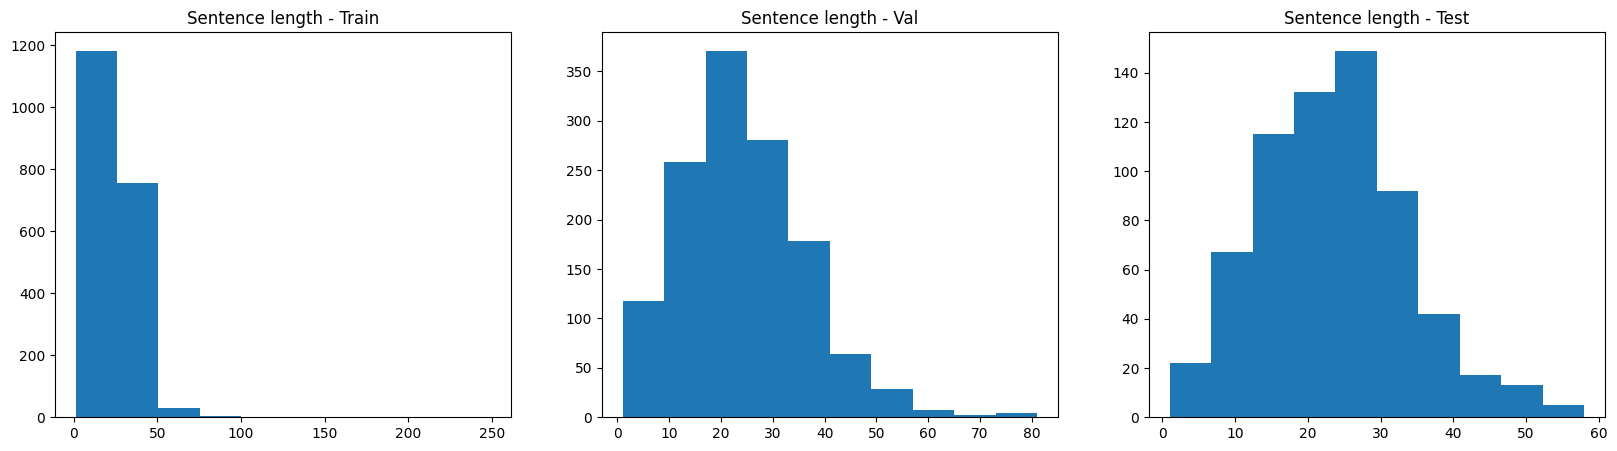

In [17]:
# better visualization of length distribution
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.hist(list(map(lambda x: len(x.split()), df.loc[(df['split'] == 'train'), ['sentence']]["sentence"])))
ax1.set_title("Sentence length - Train")
ax2.hist(list(map(lambda x: len(x.split()), df.loc[(df['split'] == 'val'), ['sentence']]["sentence"])))
ax2.set_title("Sentence length - Val")
ax3.hist(list(map(lambda x: len(x.split()), df.loc[(df['split'] == 'test'), ['sentence']]["sentence"])))
ax3.set_title("Sentence length - Test")
plt.show()

As you can see from the histograms above, the greatest part of the sentences have a length less than 50 words. So, after we can choose a number near it as maximum length parameters.

Now, let's inspect tag distribution..

In [18]:
punctuation_tags = ['#', '$', 'SYM', "''", ',', '-LRB-', '-RRB-', '.', ':', '``']

labels_col = df[["labels", "split"]]
total_tags = flatten((pos.split(' ') for pos in labels_col["labels"]))
tags = set(total_tags)

print(f"tags number = {len(tags)}, tags: {tags}")
print(f"punctuation tags = {punctuation_tags}")
print(f"valid tags = {tags.difference(punctuation_tags)}")

tags number = 45, tags: {'PRP$', 'DT', 'PDT', 'WRB', 'JJR', 'VBD', 'FW', 'NNP', 'PRP', 'SYM', 'VBG', 'CD', 'NNS', 'VBZ', 'VBP', ':', 'RP', 'NNPS', '#', "''", 'WP$', '.', 'POS', 'IN', 'RB', 'EX', '``', '$', 'MD', 'RBS', 'UH', 'WP', 'JJS', '-RRB-', ',', 'JJ', 'VBN', 'CC', 'VB', 'WDT', 'LS', '-LRB-', 'TO', 'NN', 'RBR'}
punctuation tags = ['#', '$', 'SYM', "''", ',', '-LRB-', '-RRB-', '.', ':', '``']
valid tags = {'PRP$', 'DT', 'PDT', 'WRB', 'JJR', 'VBD', 'FW', 'NNP', 'PRP', 'VBG', 'CD', 'NNS', 'VBZ', 'VBP', 'RP', 'NNPS', 'WP$', 'POS', 'IN', 'RB', 'EX', 'MD', 'RBS', 'UH', 'WP', 'JJS', 'JJ', 'VBN', 'CC', 'VB', 'WDT', 'LS', 'TO', 'NN', 'RBR'}


Total number of tags in the dataset: 93578
Number of nouns in the dataset: 13166


Text(0, 0.5, 'number of Samples')

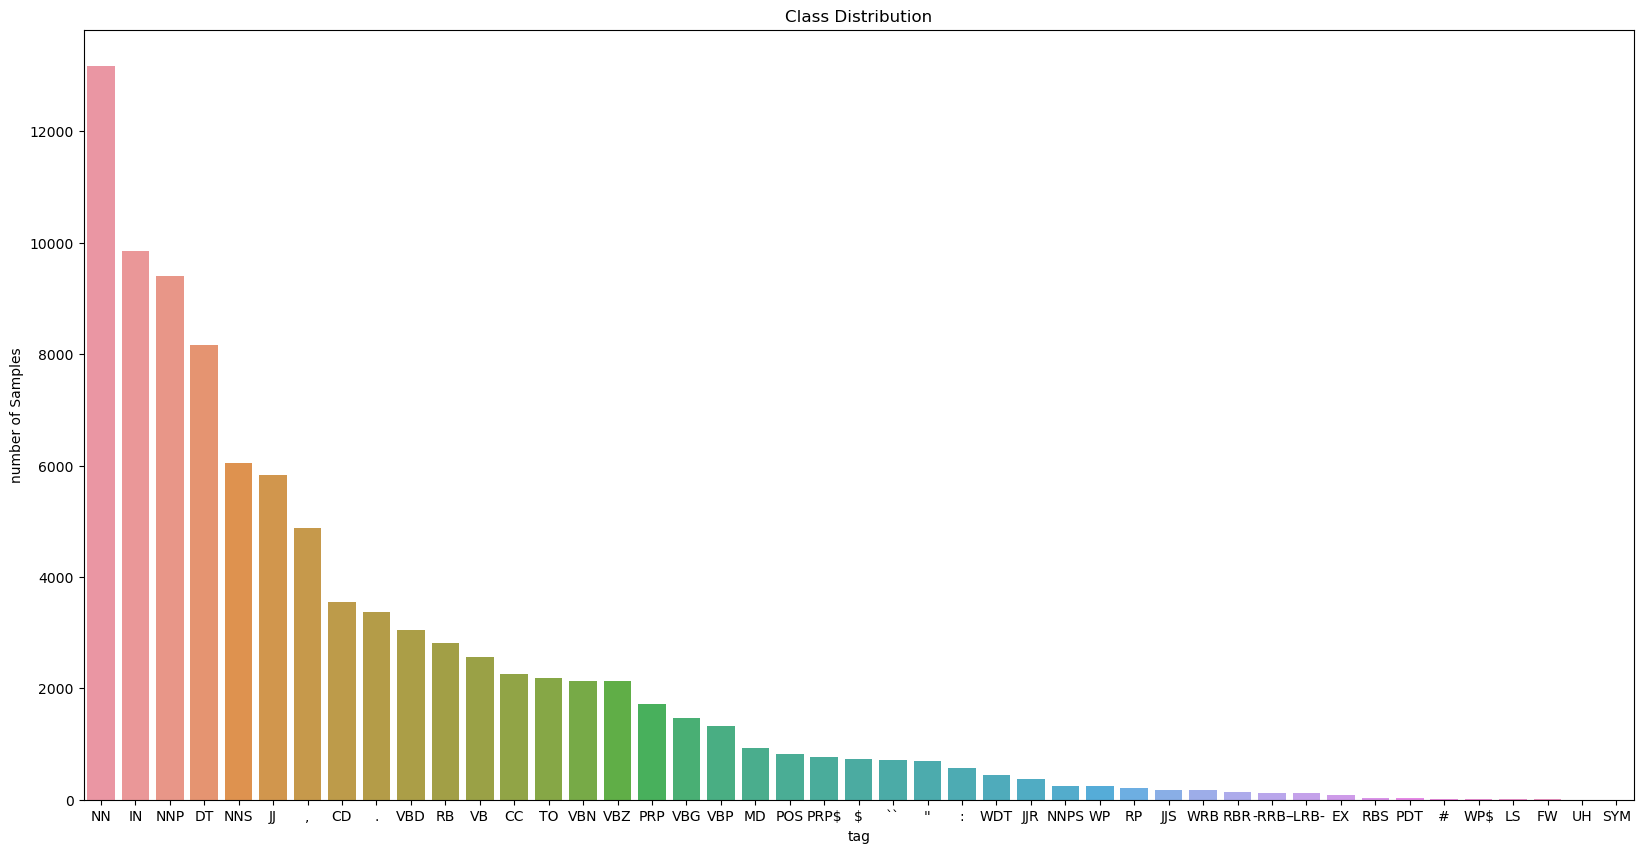

In [32]:
counts = dict(Counter(total_tags))
tags_df = pd.DataFrame(data=counts, index=[0])

print(f"Total number of tags in the dataset: {len(total_tags)}")
print(f"Number of nouns in the dataset: {counts['NN']}")
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(tags_df.sort_values(0, ascending=False, axis=1))
plt.title('Class Distribution')
plt.xlabel('tag')
plt.ylabel('number of Samples')

From this plot we can see 2 important factor that we will be consider after during training:
- the majority of tag are concentrated within few tags. More than 50% of the total tags belong to 5 class, causing an heavy unbalancing of the datasets.
- there are tags that have are very very small comparing the others in terms of presence, so it will be so hard to classify good during inference phase.

## Embedding model

In [33]:
emb_dim = 100
emb_model = gloader.load(f"glove-wiki-gigaword-{emb_dim}")

embedding_words = emb_model.index_to_key
print(f"Total words in embedding downloaded is: {len(embedding_words)}")

[==================================================] 100.0% 128.1/128.1MB downloaded
Total words in embedding downloaded is: 400000


In [40]:
# check if there are some words not lowercase
lower_words = [word for word in embedding_words if word.islower()]
print(f"Total numbers of lower words {len(lower_words)} with respect to total words in embeddings {len(embedding_words)} \n")

upper_words = [word for word in embedding_words if word[0].isupper() or word.isupper()]
print(f"The number of words starting with uppercase chars in the embedding are: {len(upper_words)} \n")

# check if there are numbers and words with digits
embedding_with_digits = set([word for word in embedding_words if any(char.isdigit() for char in word)])
embedding_numbers = set([word for word in embedding_with_digits if bool(re.match(r'^[\-]?[0-9]*[\.,]?[0-9]+$', word))])
embedding_non_numbers = embedding_with_digits.difference(embedding_numbers)

print(f"Total embeddings containing digits are: {len(embedding_with_digits)}")
print(f"Set 1 - embeddings of numbers are: {len(embedding_numbers)}")
print(f"Set 2 - embeddings with digits but that are not only number: {len(embedding_with_digits.difference(embedding_numbers))}")

Total numbers of lower words 366039 with respect to total words in embeddings 400000 

The number of words starting with uppercase chars in the embedding are: 0 

Total embeddings containing digits are: 48970
Set 1 - embeddings of numbers are: 25570
Set 2 - embeddings with digits but that are not only number: 23400


From thi little inspection above we can see that glove not contains any embedding vector associated to a word that starts with an upper-case charaters or is fully uppercase. So, during the creation of the embedding matrix it's make sense to search only lower-case words.

### Tokenization
Using string as input for the NN is really not recommended, so we need a way to transform a text to another representation that fit better for the network. Using tokenization is the key. It transform each word to a number following a choosen criteria, mantaining the ability to coming back to plain text if it needed. There are many possile alternative in how tokenize the text, we choose to use a **Word Tokenization**. 

In [42]:
class MyTokenizer:

  def __init__(self, tokenizer_args):
    self.tokenizer = Tokenizer(**tokenizer_args)
    self.word_to_idx = {}
    self.idx_to_word = {}
    self.vocab_size = 0
    self.oov_split_terms = [None, None, None]

  def get_oov_terms(self, emb_model, split):
    prev_oov_term = set([oov_term for oov_terms in self.oov_split_terms if oov_terms is not None for oov_term in oov_terms])
    oov = set(self.word_to_idx.keys()).difference(set(emb_model.index_to_key) | prev_oov_term)
    self.oov_split_terms[split] = oov
    return oov

  def build_vocab(self, data):
    self.tokenizer.fit_on_texts(data)
    self.word_to_idx = self.tokenizer.word_index
    self.idx_to_word = self.tokenizer.index_word
    self.vocab_size =  len(self.word_to_idx)
  
  def texts_to_sequences(self, data):
    return self.tokenizer.texts_to_sequences(data)

In [41]:
word_tokenizer_args = {
    "lower": False,
    "oov_token": "UNK",
    "filters": ""
}

tag_tokenizer_args = {
    "lower": False,
    "filters": ""
}

train = df.loc[df['split'] == "train"]
val = df.loc[df['split'] == "val"]
test = df.loc[df['split'] == "test"]

val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [43]:
# V1 (in our assignment )
tokenizer = MyTokenizer(word_tokenizer_args)

# V2 = V1 + OOV1
tokenizer.build_vocab(train.sentence.values)
print('Checking OOV terms...')
train_oov = tokenizer.get_oov_terms(emb_model, split=0) # split 0 means that it's for training 
print('Total number of words is: {}'.format(tokenizer.vocab_size))
print('Total number of train OOV words is: {}'.format(len(train_oov)))
print('Percentage of OOV words w.r.t the Glove vocabulary (V2): {:.1f}%'.format(len(train_oov) / tokenizer.vocab_size * 100)) 
print()

# V3
tokenizer.build_vocab(val.sentence.values)
print('Checking OOV terms...')
val_oov = tokenizer.get_oov_terms(emb_model, split=1) # split 1 means that it's for val 
print('Total number of words is: {}'.format(tokenizer.vocab_size))
print('Total number of val OOV words is: {}'.format(len(val_oov)))
print('Percentage of OOV words w.r.t the V2 vocabulary (V3): {:.1f}%'.format(len(val_oov) / tokenizer.vocab_size * 100))
print()

# V4
tokenizer.build_vocab(test.sentence.values)
print('Checking OOV terms...')
test_oov = tokenizer.get_oov_terms(emb_model, split=2) # split 2 means that it's for test 
print('Total number of words is: {}'.format(tokenizer.vocab_size))
print('Total number of test OOV words is: {}'.format(len(test_oov)))
print('Percentage of OOV words w.r.t the V3 vocabulary (V4): {:.1f}%'.format(len(test_oov) / tokenizer.vocab_size * 100))

Checking OOV terms...
Total number of words is: 8009
Total number of train OOV words is: 2346
Percentage of OOV words w.r.t the Glove vocabulary (V2): 29.3%

Checking OOV terms...
Total number of words is: 10819
Total number of val OOV words is: 944
Percentage of OOV words w.r.t the V2 vocabulary (V3): 8.7%

Checking OOV terms...
Total number of words is: 11968
Total number of test OOV words is: 455
Percentage of OOV words w.r.t the V3 vocabulary (V4): 3.8%


## Reduce OOV words in embedding matrix creation
In order to reduce the number of Out Of Vocabulary words a multiple search with different strategy is applied for each of those word. Before moving to explain what we did, we want to say that there isn't a good answer to solve this problem. Some of this are very trivial, other are  thoose we thought fit better in that situation. No study or paper are been did or considered to justify our choices. 

Now, once a word is labeled as OOV the following steps are done in order:
1. the corresponding lower word is checked
2. if it isn't found, we check if we are dealing with an hyphenated word. In this case, we use as embedding vector the average of the individual word vectors
3. Finally, if also the previous search failed, the word is considered unknown and used as vector the average vector of whole glove vectors

In [46]:
def create_emb_matrix(emb_model, word_to_index, emb_dim, oov_terms, verbose=False):
  avg_emb_vector = np.mean(emb_model[emb_model.index_to_key], axis=0)
  emb_matrix = np.zeros((len(word_to_index)+1, emb_dim), dtype=np.float32)
  count_lower, count_hypnd, count_avg_emb = [0, 0, 0]

  for word, idx in tqdm(word_to_index.items()):
    if word not in oov_terms:
      emb_vector = emb_model[word]
    else:
      try: 
        emb_vector = emb_model[word.lower()]
        count_lower +=1
      except (KeyError, TypeError):
        try:
          word_split = word.split("-")
          if len(word_split) >= 2:
            word_emb = []
            for w in word_split:
              word_emb.append(emb_model[w.lower()])
            emb_vector = np.mean(np.array(word_emb), axis=0)
            count_hypnd += 1
          else:
            emb_vector = avg_emb_vector
            count_avg_emb += 1
        except (KeyError, TypeError):
          emb_vector = avg_emb_vector
          count_avg_emb += 1

    emb_matrix[idx] = emb_vector

  if verbose:
    print()
    print(f"Total number of OOV terms: {len(oov_terms)}")
    print(f"Number of lower OOV terms: {count_lower}")
    print(f"Number of hypened OOV terms: {count_hypnd}")
    print(f"Number of average vector embedding OOV terms: {count_avg_emb}")

  return emb_matrix

In [47]:
tot_oov_terms = set(train_oov | val_oov | test_oov)
embedding_matrix = create_emb_matrix(emb_model, tokenizer.word_to_idx, emb_dim, tot_oov_terms, verbose=True)

100%|██████████| 11968/11968 [00:00<00:00, 333768.39it/s]


Total number of OOV terms: 3745
Number of lower OOV terms: 3059
Number of hypened OOV terms: 371
Number of average vector embedding OOV terms: 315


## Creation of training data

In [68]:
# removing useless columns like "files" and "split"
x_train = train.sentence.values
y_train = train.labels.values

x_val = val.sentence.values
y_val = val.labels.values

x_test = test.sentence.values
y_test = test.labels.values

In [69]:
print("** Raw word and tags sentence **", "\n", "-"*100, "\n")
print('Sentence: ',x_train[0], '\n')
print('tag: ', y_train[0], '\n')
print()

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)  
x_test = tokenizer.texts_to_sequences(x_test)  

tag_tokenizer = MyTokenizer(tag_tokenizer_args)
tag_tokenizer.build_vocab(y_train)
y_train = tag_tokenizer.texts_to_sequences(y_train)
y_val = tag_tokenizer.texts_to_sequences(y_val)  
y_test = tag_tokenizer.texts_to_sequences(y_test)  

print("** Tokenized word and tags sentence **", "\n", "-"*100, "\n")
print('Sentence: ',x_train[0], '\n')
print('Tags: ', y_train[0], '\n')
print()

print(f"Word vocabulary size: {tokenizer.vocab_size}")
print(f"Tag vocabulary size: {tag_tokenizer.vocab_size}")

** Raw word and tags sentence ** 
 ---------------------------------------------------------------------------------------------------- 

Sentence:  Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 . 

tag:  NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN NNP CD . 


** Tokenized word and tags sentence ** 
 ---------------------------------------------------------------------------------------------------- 

Sentence:  [5765, 3929, 2, 2072, 81, 429, 2, 38, 2481, 3, 336, 26, 7, 2073, 308, 430, 2074, 4] 

Tags:  [2, 2, 7, 11, 5, 6, 7, 20, 12, 4, 1, 3, 4, 6, 1, 2, 11, 8] 


Word vocabulary size: 11968
Tag vocabulary size: 45


In [70]:
max_seq_len = int(np.quantile([len(seq) for seq in x_train], 0.99))
print(f"The 99th % of the sequence length is {max_seq_len} and we will use is it as maximum length for input sequences")

x_train = pad_sequences(x_train, maxlen = max_seq_len)
x_val = pad_sequences(x_val, maxlen = max_seq_len)
x_test = pad_sequences(x_test, maxlen = max_seq_len)

y_train = pad_sequences(y_train, maxlen = max_seq_len)
y_val = pad_sequences(y_val, maxlen = max_seq_len)
y_test = pad_sequences(y_test, maxlen = max_seq_len)

y_train = to_categorical(y_train, num_classes=tag_tokenizer.vocab_size+1)
y_val = to_categorical(y_val, num_classes=tag_tokenizer.vocab_size+1)
y_test = to_categorical(y_test, num_classes=tag_tokenizer.vocab_size+1)

The 99th % of the sequence length is 56 and we will use is it as maximum length for input sequences


## Build the models

We try several model as it's written in the assignment: starting from the baseline which is lstm + fc

In [72]:
# defining a function which display graphically the train loss with respect to the validation one

def display_history(history, *args):
  for arg in args:
    train = history.history[arg]
    val = history.history[f"val_{arg}"]

    plt.plot(train)
    plt.plot(val)
    plt.grid()
    plt.title(f"{arg} during training")
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

train_params = {
    'epochs': 100,
    'batch_size': 128,
    'verbose': 1,
    'callbacks': [
    keras.callbacks.EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True)
    #     keras.callbacks.ModelCheckpoint(
    #         file_path= '/checkpoint'
    #         save_weights_only=True, 
    #         save_best_only=True, 
    #         monitor='val_loss', 
    #         mode='min')
                 ]
}

In [83]:
# define a class for building the models on the bases of some booleans which define the layers we have to add
def categorical_focal_loss(gamma=2., alpha=.25):
    def categorical_focal_loss_fixed(y_true, y_pred):
        y_pred /= tf.keras.backend.sum(y_pred, axis=-1, keepdims=True)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.keras.backend.pow(1 - y_pred, gamma) * cross_entropy
        return tf.keras.backend.sum(loss, axis=1)
    return categorical_focal_loss_fixed

class Model_creation(keras.Sequential):

  def __init__(self, Units, lstm, gru, dense2, lstm2, dropout, dense_units=None):
    super().__init__()
    self.add(Embedding(tokenizer.vocab_size+1,
                         emb_dim,
                         weights = [embedding_matrix],
                         input_length=max_seq_len,
                         mask_zero = True,
                         trainable = False))
    
    if lstm:
          self.add(Bidirectional(LSTM(Units, return_sequences=True, dropout=dropout)))
    if gru:
          self.add(Bidirectional(GRU(Units, return_sequences=True, dropout=dropout)))

    if lstm2: 
      self.add(Bidirectional(LSTM(Units, return_sequences=True, dropout=dropout)))

    if dense2: self.add(TimeDistributed(Dense(dense_units, activation = 'relu')))

    self.add(TimeDistributed(Dense(tag_tokenizer.vocab_size+1, activation = 'softmax')))

    self.compile(#loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer= keras.optimizers.Adam(learning_rate=1e-3),
                      metrics=['categorical_accuracy'])
    self.summary()

  def fit_model(self):
    history = self.fit(x_train, y_train, validation_data=(x_val, y_val), **train_params)
    return history

  def get_loss_acc(self): 
    loss, accuracy = self.evaluate(x_test, y_test, verbose = 1)
    print("")
    print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

### Model: BiLSTM + TD-Dense

We started trying several combination of parameters only on the base architecture, in order to see what information we can bring with us later in other models.
In this way we also inspect limitation of the task and we understand why complex architectures could work better.

In [84]:
lstm_model = Model_creation(100, True, False, False, False, dropout=0)
lstm_history = lstm_model.fit_model()
lstm_model.get_loss_acc()

Model: "model_creation_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 56, 100)           1196900   
                                                                 
 bidirectional_2 (Bidirecti  (None, 56, 200)           160800    
 onal)                                                           
                                                                 
 time_distributed_2 (TimeDi  (None, 56, 46)            9246      
 stributed)                                                      
                                                                 
Total params: 1366946 (5.21 MB)
Trainable params: 170046 (664.24 KB)
Non-trainable params: 1196900 (4.57 MB)
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 9s 227ms/step - loss: 3.1833 - categorical_accuracy: 0.1683 - val_loss: 2.7861 - val_c

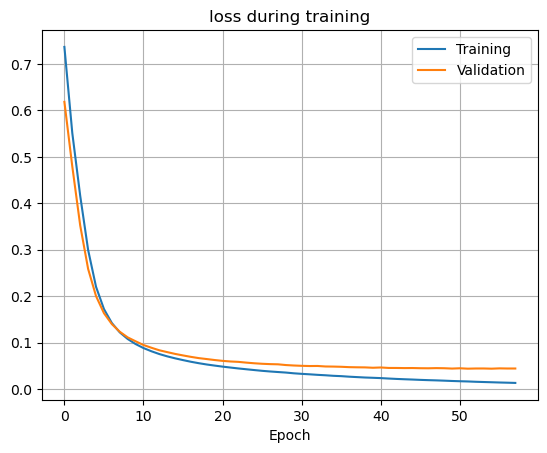

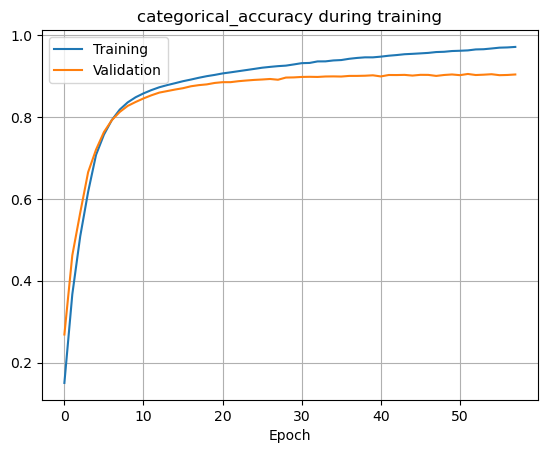

In [77]:
display_history(lstm_history, "loss", "categorical_accuracy")

#### Model: BiLSTM + TD-Dense + dropout

Trying the same model with dropout, in order to see if we can improve results

Why? because model tends to learn quickly the task (that's good), but this factor translates into overfitting due to a not so general and well spaced dataset

In [37]:
lstm_model_dropout = Model_creation(100, True, False, False, False, dropout=0.2)
lstm_dropout_history = lstm_model_dropout.fit_model()
lstm_model_dropout.get_loss_acc()

Model: "model_creation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 56, 50)            598450    
                                                                 
 bidirectional_1 (Bidirectio  (None, 56, 200)          120800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 56, 46)           9246      
 tributed)                                                       
                                                                 
Total params: 728,496
Trainable params: 130,046
Non-trainable params: 598,450
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 14s 252ms/step - loss: 3.0820 - categorical_accuracy: 0.1846 - val_loss: 2.6543 - val_categorical_accuracy: 0.2997
Ep

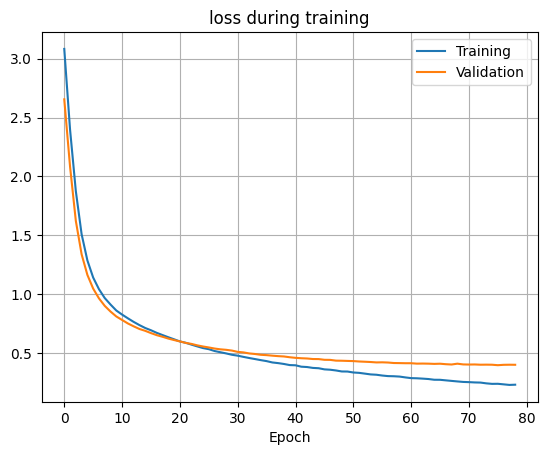

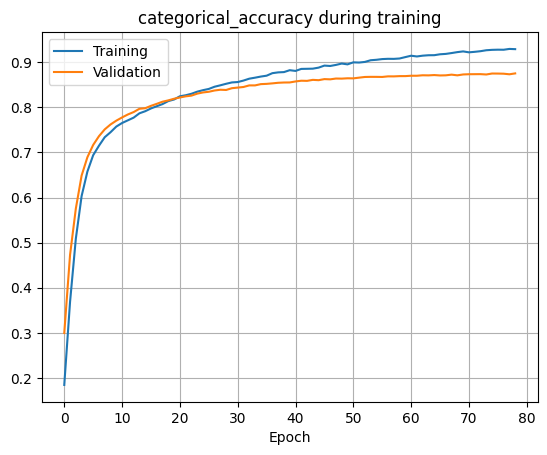

In [38]:
display_history(lstm_dropout_history, "loss", "categorical_accuracy")

It seems to improve a bit the model, so we try several combination of hyperparameters

In [39]:
lstm_model_dropout2 = Model_creation(150, True, False, False, False, dropout=0.3)
lstm_dropout2_history = lstm_model_dropout2.fit_model()
lstm_model_dropout2.get_loss_acc()

Model: "model_creation_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 56, 50)            598450    
                                                                 
 bidirectional_2 (Bidirectio  (None, 56, 300)          241200    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 56, 46)           13846     
 tributed)                                                       
                                                                 
Total params: 853,496
Trainable params: 255,046
Non-trainable params: 598,450
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 17s 287ms/step - loss: 2.9497 - categorical_accuracy: 0.2226 - val_loss: 2.5283 - val_categorical_accuracy: 0.3674
Ep

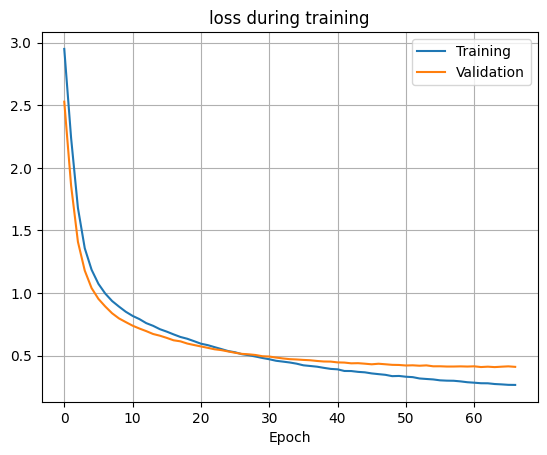

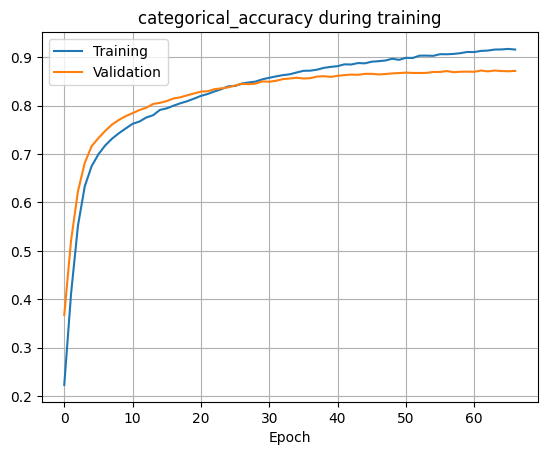

In [40]:
display_history(lstm_dropout2_history, "loss", "categorical_accuracy")

In [41]:
lstm_model_dropout3 = Model_creation(50, True, False, False, False, dropout=0.1)
lstm_dropout3_history = lstm_model_dropout3.fit_model()
lstm_model_dropout3.get_loss_acc()

Model: "model_creation_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 56, 50)            598450    
                                                                 
 bidirectional_3 (Bidirectio  (None, 56, 100)          40400     
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 56, 46)           4646      
 tributed)                                                       
                                                                 
Total params: 643,496
Trainable params: 45,046
Non-trainable params: 598,450
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 11s 162ms/step - loss: 3.2419 - categorical_accuracy: 0.1333 - val_loss: 2.8710 - val_categorical_accuracy: 0.2286
Epo

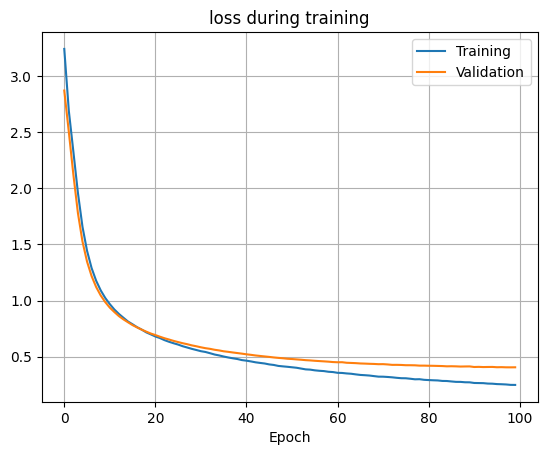

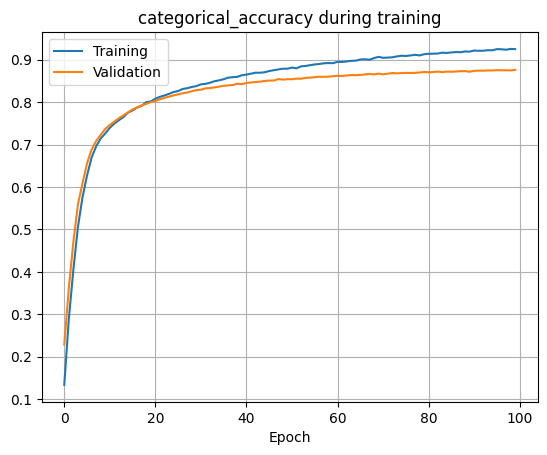

In [42]:
display_history(lstm_dropout3_history, "loss", "categorical_accuracy")

In [43]:
lstm_model_dropout4 = Model_creation(150, True, False, False, False, dropout=0.1)
lstm_dropout4_history = lstm_model_dropout4.fit_model()
lstm_model_dropout4.get_loss_acc()

Model: "model_creation_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 56, 50)            598450    
                                                                 
 bidirectional_4 (Bidirectio  (None, 56, 300)          241200    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 56, 46)           13846     
 tributed)                                                       
                                                                 
Total params: 853,496
Trainable params: 255,046
Non-trainable params: 598,450
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 18s 334ms/step - loss: 2.9298 - categorical_accuracy: 0.2314 - val_loss: 2.5098 - val_categorical_accuracy: 0.3577
Ep

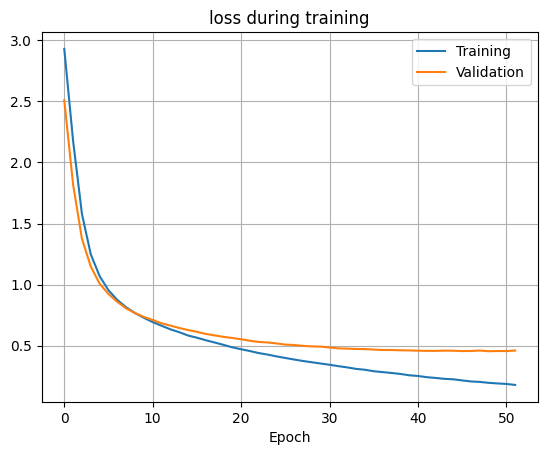

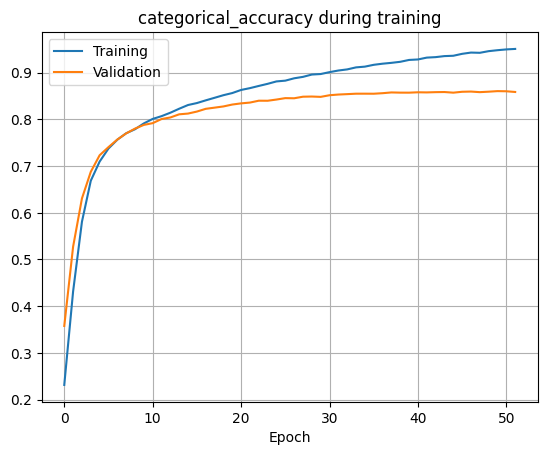

In [44]:
display_history(lstm_dropout4_history, "loss", "categorical_accuracy")

In [45]:
lstm_model_dropout5 = Model_creation(50, True, False, False, False, dropout=0.2)
lstm_dropout5_history = lstm_model_dropout5.fit_model()
lstm_model_dropout5.get_loss_acc()

Model: "model_creation_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 56, 50)            598450    
                                                                 
 bidirectional_5 (Bidirectio  (None, 56, 100)          40400     
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 56, 46)           4646      
 tributed)                                                       
                                                                 
Total params: 643,496
Trainable params: 45,046
Non-trainable params: 598,450
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 11s 167ms/step - loss: 3.2757 - categorical_accuracy: 0.1342 - val_loss: 2.9012 - val_categorical_accuracy: 0.2252
Epo

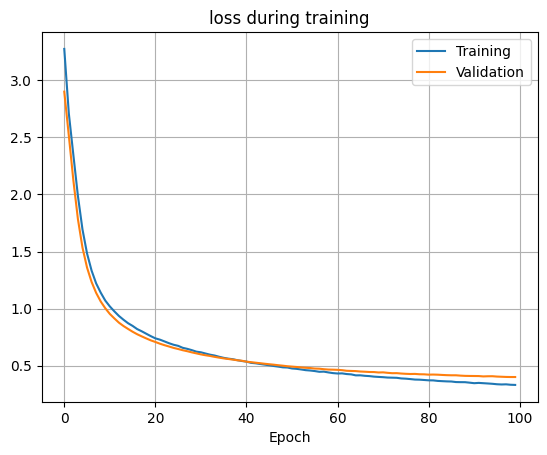

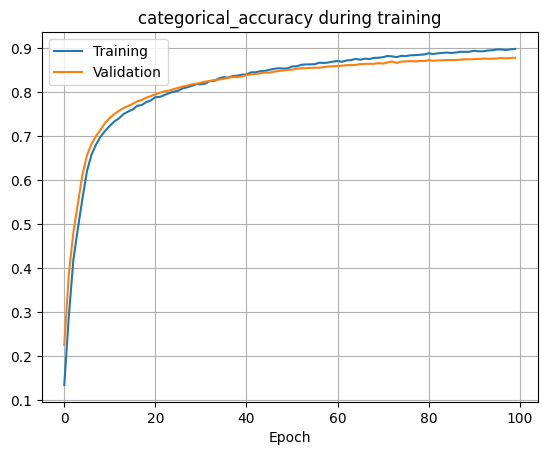

In [46]:
display_history(lstm_dropout5_history, "loss", "categorical_accuracy")

In [47]:
lstm_model_dropout6 = Model_creation(250, True, False, False, False, dropout=0.3)
lstm_dropout6_history = lstm_model_dropout6.fit_model()
lstm_model_dropout6.get_loss_acc()

Model: "model_creation_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 56, 50)            598450    
                                                                 
 bidirectional_6 (Bidirectio  (None, 56, 500)          602000    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 56, 46)           23046     
 tributed)                                                       
                                                                 
Total params: 1,223,496
Trainable params: 625,046
Non-trainable params: 598,450
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 22s 468ms/step - loss: 2.8203 - categorical_accuracy: 0.2447 - val_loss: 2.3325 - val_categorical_accuracy: 0.3824


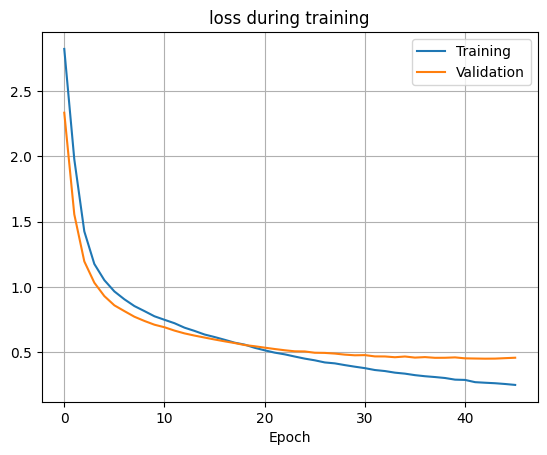

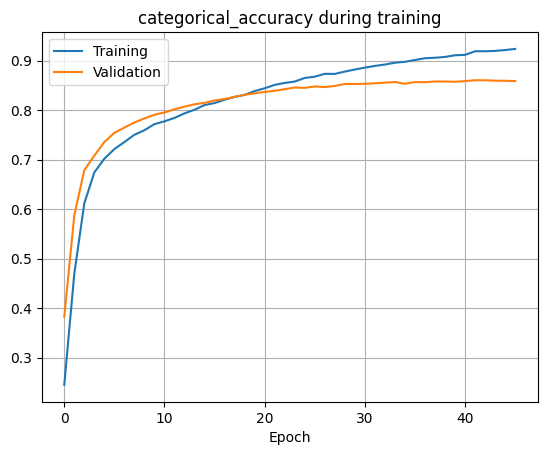

In [48]:
display_history(lstm_dropout6_history, "loss", "categorical_accuracy")

### Model: 2xBiLSTM + TD-Dense

In [49]:
lstm2_model = Model_creation(100, True, False, False, True, dropout=0.2)
lstm2_history = lstm2_model.fit_model()
lstm2_model.get_loss_acc()

Model: "model_creation_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 56, 50)            598450    
                                                                 
 bidirectional_7 (Bidirectio  (None, 56, 200)          120800    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 56, 200)          240800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 56, 46)           9246      
 tributed)                                                       
                                                                 
Total params: 969,296
Trainable params: 370,846
Non-trainable params: 598,450
______________________________________

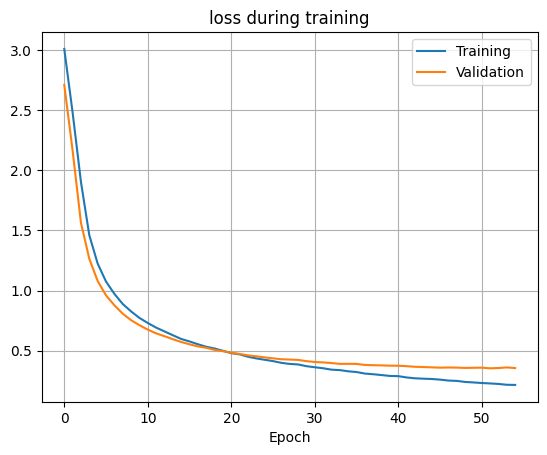

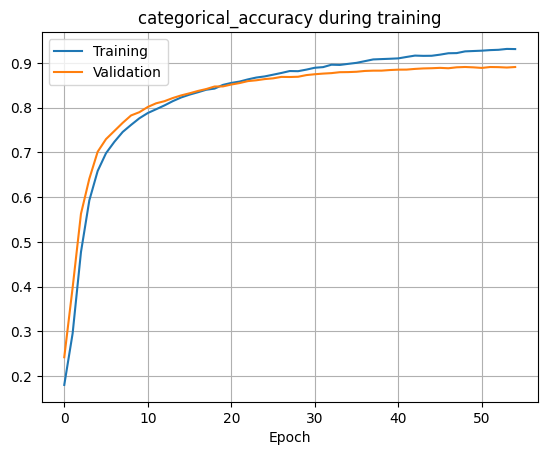

In [50]:
display_history(lstm2_history, "loss", "categorical_accuracy")

In [104]:
lstm2_model2 = Model_creation(100, True, False, False, True, dropout=0.3)
lstm2_03_history = lstm2_model2.fit_model()
lstm2_model2.get_loss_acc()

Model: "model_creation_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 56, 50)            598450    
                                                                 
 bidirectional_12 (Bidirecti  (None, 56, 200)          120800    
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 56, 200)          240800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 56, 46)           9246      
 stributed)                                                      
                                                                 
Total params: 969,296
Trainable params: 370,846
Non-trainable params: 598,450
_____________________________________

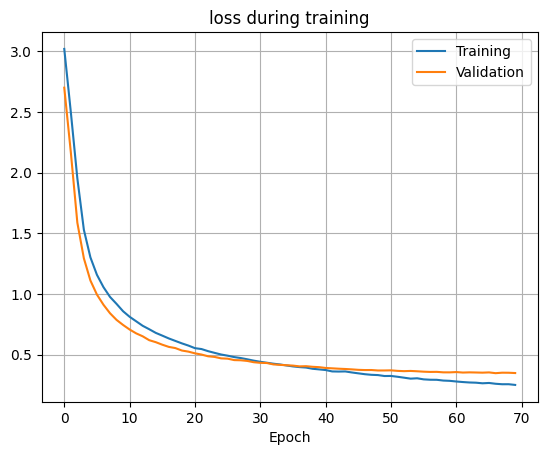

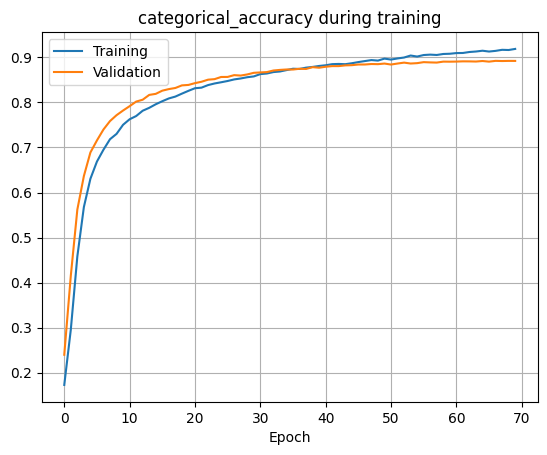

In [106]:
display_history(lstm2_03_history, "loss", "categorical_accuracy")

In [105]:
# trying to double the units, using best dropouts from previous attempt
lstm2_model3 = Model_creation(200, True, False, False, True, dropout=0.3)
lstm2_model3_history = lstm2_model3.fit_model()
lstm2_model3.get_loss_acc()

Model: "model_creation_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 56, 50)            598450    
                                                                 
 bidirectional_14 (Bidirecti  (None, 56, 400)          401600    
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 56, 400)          961600    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 56, 46)           18446     
 stributed)                                                      
                                                                 
Total params: 1,980,096
Trainable params: 1,381,646
Non-trainable params: 598,450
_________________________________

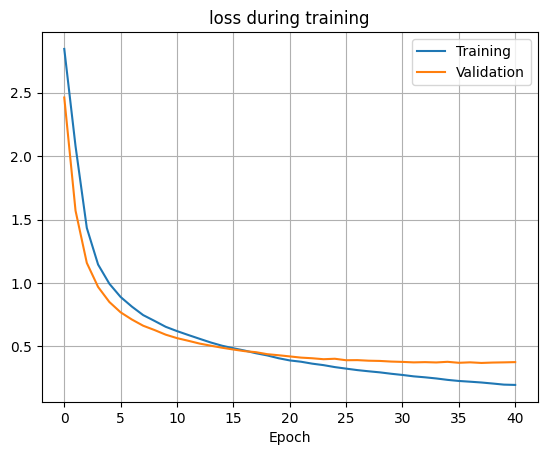

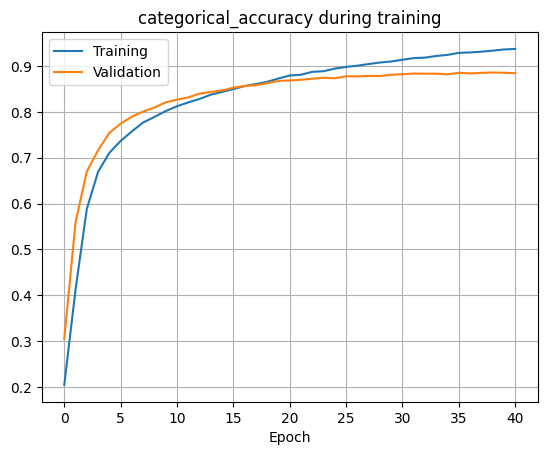

In [107]:
display_history(lstm2_model3_history, "loss", "categorical_accuracy")

### Model: Bi-GRU + TD-Dense

In [51]:
gru_model = Model_creation(128, False, True, False, False, dropout=0.2)
gru_model_history = gru_model.fit_model()
gru_model.get_loss_acc()

Model: "model_creation_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 56, 50)            598450    
                                                                 
 bidirectional_9 (Bidirectio  (None, 56, 256)          138240    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 56, 46)           11822     
 tributed)                                                       
                                                                 
Total params: 748,512
Trainable params: 150,062
Non-trainable params: 598,450
_________________________________________________________________
Epoch 1/100
31/31 [==============================] - 13s 236ms/step - loss: 2.9021 - categorical_accuracy: 0.2476 - val_loss: 2.3031 - val_categorical_accuracy: 0.4220
Ep

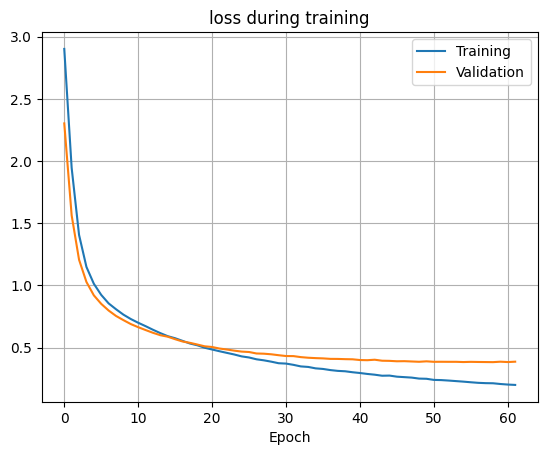

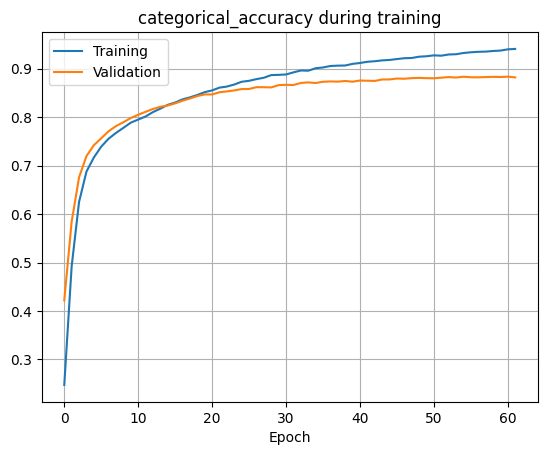

In [52]:
display_history(gru_model_history, "loss", "categorical_accuracy")

### Model: BiLSTM + 2xTD-Dense

In [55]:
Dense2_model2 = Model_creation(128, True, False, True, False, dropout=0.2, dense_units=96)
Dense2_model2_history = Dense2_model2.fit_model()
Dense2_model2.get_loss_acc()

Model: "model_creation_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 56, 50)            598450    
                                                                 
 bidirectional_11 (Bidirecti  (None, 56, 256)          183296    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 56, 96)           24672     
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 56, 46)           4462      
 stributed)                                                      
                                                                 
Total params: 810,880
Trainable params: 212,430
Non-trainable params: 598,450
_____________________________________

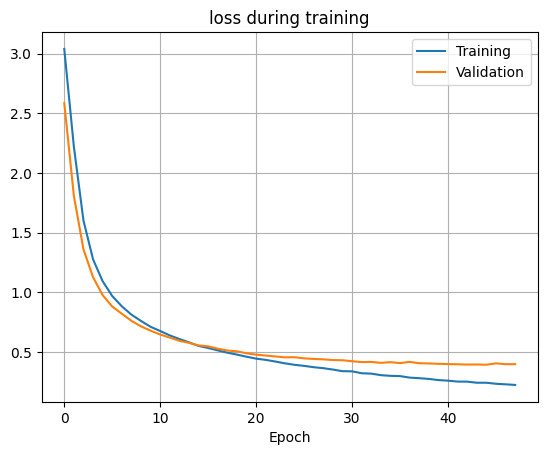

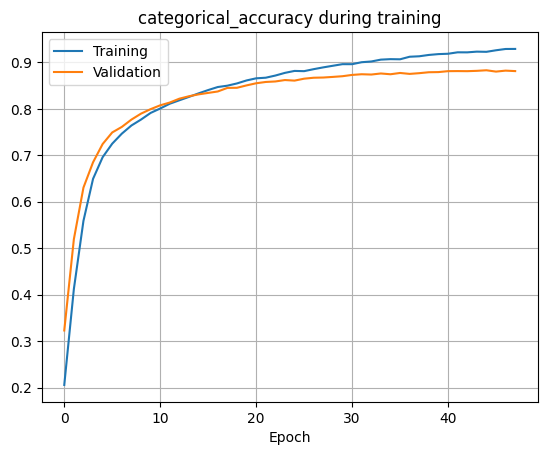

In [56]:
display_history(Dense2_model2_history, "loss", "categorical_accuracy")

## Models evaluation

In [78]:
punct_list = ["SYM", "``", "''", "-LRB-", "-RRB-"] + [punct for punct in string.punctuation]
punct_tag_idxs = [tag_tokenizer.word_to_idx[token] for token in punct_list if token in list(tag_tokenizer.word_to_idx.keys())]
print(f"Puntaction class present in the dataset: {[tag_tokenizer.idx_to_word[idx] for idx in punct_tag_idxs]}")

Puntaction class present in the dataset: ['SYM', '``', "''", '-LRB-', '-RRB-', '#', '$', ',', '.', ':']


In [79]:
# computing labels to print in the stats
labels = [i for i in tag_tokenizer.idx_to_word.keys() if i not in punct_tag_idxs]
target_names = [tag_tokenizer.idx_to_word[i] for i in labels]

In [80]:
# Utils
def remove_pad(y_true, y_pred):
  y_true_no_pad = []
  y_pred_no_pad = []
  for i in range(len(y_true)):
    if y_true[i] != 0:
      y_true_no_pad.append(y_true[i])    
      y_pred_no_pad.append(y_pred[i]) 
  return y_true_no_pad, y_pred_no_pad

def compute_f1(y_true, y_pred, title):
  f1_value = f1_score(y_true,
            y_pred,
            average='macro',
            labels=[i for i in tag_tokenizer.idx_to_word.keys() if i not in punct_tag_idxs],
            zero_division=0)
  print(f"F1-score on {title}: {f1_value}")
  return f1_value

# taking into account classes with 0 support as well predicted
def compute_f1_zero_excluded(y_true, y_pred, title):
  f1_value = f1_score(y_true,
            y_pred,
            average='macro',
            labels=[i for i in tag_tokenizer.idx_to_word.keys() if i not in punct_tag_idxs],
            zero_division=1)
  print(f"F1-score on {title}: {f1_value}")
  return f1_value

def evaluation(model, x_val=x_val, x_test=x_test, y_val=y_val, y_test=y_test):
  # prediction on validation and test set
  print(f"Prediction...")
  y_pred_val = model.predict(x_val, batch_size=64)
  y_pred_test = model.predict(x_test, batch_size=64)

  print()

  # concatenation of sentences, row = token,  col = prediction values for each class
  y_pred_val = np.reshape(y_pred_val, (y_pred_val.shape[0]*y_pred_val.shape[1], y_pred_val.shape[2]))
  y_pred_test = np.reshape(y_pred_test, (y_pred_test.shape[0]*y_pred_test.shape[1], y_pred_test.shape[2]))

  # reshape of true values to commpare them
  y_val_true = np.reshape(y_val, (y_val.shape[0]*y_val.shape[1], y_val.shape[2]))
  y_test_true = np.reshape(y_test, (y_test.shape[0]*y_test.shape[1], y_test.shape[2]))

  y_val_true_no_pad, y_pred_val_no_pad = remove_pad(np.argmax(y_val_true, axis=1), np.argmax(y_pred_val, axis=1))
  y_test_true_no_pad, y_pred_test_no_pad = remove_pad(np.argmax(y_test_true, axis=1), np.argmax(y_pred_test, axis=1))

  print("Printing stats...\n")
  print("-"*25, "F1 results", "-"*25)
  compute_f1(y_val_true_no_pad, y_pred_val_no_pad, "VALIDATION set")
  f1_test = compute_f1(y_test_true_no_pad, y_pred_test_no_pad, "TEST set")
  print("-"*62)

  print()

  print("Printing confusion matrix...\n")
  print_conf_matrix(y_test_true, y_pred_test)
  print()
  print_stats(y_test_true_no_pad, y_pred_test_no_pad, labels = labels, target_names = target_names)

  return f1_test


def print_conf_matrix(y_test_true, y_pred_test):
  conf_matrix = confusion_matrix(np.argmax(y_test_true, axis=1),
                               np.argmax(y_pred_test, axis=1),
                               normalize=None,
                               labels=[i for i in tag_tokenizer.idx_to_word.keys()])

  df_cfm = pd.DataFrame(conf_matrix,
                        index = [tag for tag in tag_tokenizer.idx_to_word.keys()],
                        columns = [tag for tag in tag_tokenizer.idx_to_word.keys()])

  plt.figure(figsize = (15,8))
  sns.heatmap(df_cfm, annot=True, annot_kws={"size": 7}, cmap="Blues")
  plt.show()

def print_stats(y_test_true_no_pad, y_pred_test_no_pad, labels = labels, target_names = target_names):
  print(classification_report(y_test_true_no_pad, y_pred_test_no_pad, labels = labels, target_names = target_names))

In [81]:
# var for storing f1 score on test set for each model
f1_scores = {}

### BiLSTM + TD-Dense





F1-score on VALIDATION set: 0.7530011205474029 <br>
F1-score on TEST set: 0.7336103450344119

Prediction...
11/11 [==============================] - 0s 16ms/step

Printing stats...

------------------------- F1 results -------------------------
F1-score on VALIDATION set: 0.7409727191625564
F1-score on TEST set: 0.7359375071988247
--------------------------------------------------------------

Printing confusion matrix...



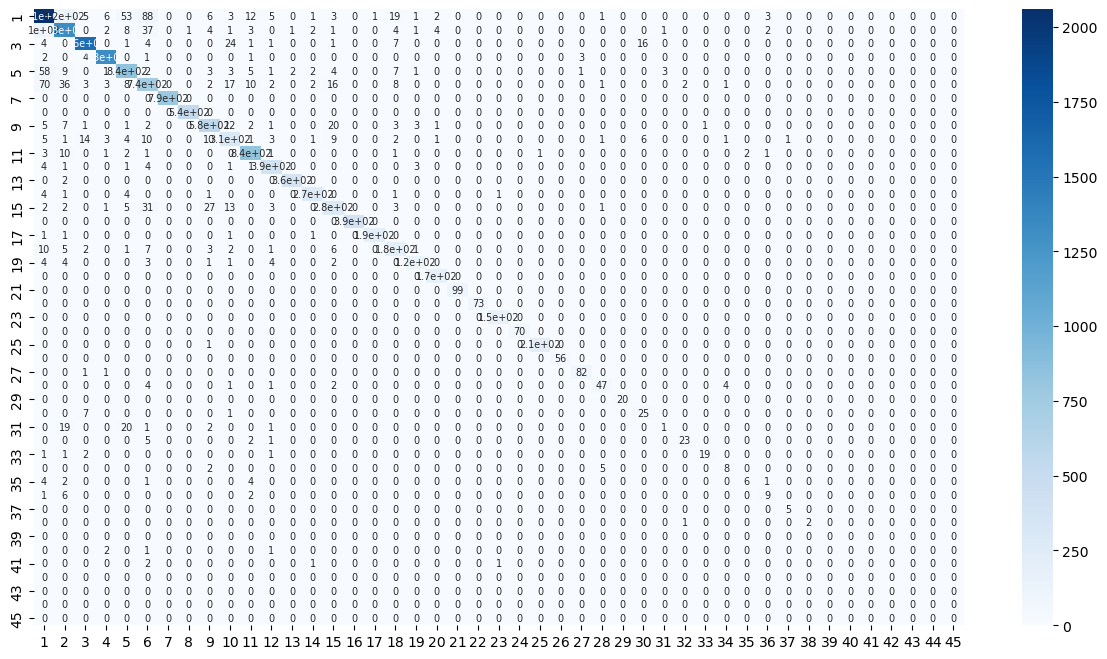


              precision    recall  f1-score   support

          NN       0.88      0.86      0.87      2383
         NNP       0.86      0.88      0.87      1502
          IN       0.98      0.96      0.97      1630
          DT       0.99      0.99      0.99      1335
         NNS       0.89      0.89      0.89       941
          JJ       0.78      0.80      0.79       918
         VBD       0.90      0.91      0.90       634
          RB       0.79      0.81      0.80       381
          CD       0.95      0.97      0.96       858
          VB       0.93      0.96      0.95       403
          CC       0.99      0.99      0.99       366
         VBZ       0.96      0.96      0.96       280
         VBN       0.81      0.76      0.79       366
          TO       1.00      1.00      1.00       386
         PRP       0.99      0.98      0.99       192
         VBG       0.77      0.83      0.80       221
         VBP       0.92      0.86      0.89       134
          MD       0.95   

In [85]:
f1_lstm = evaluation(lstm_model)
f1_scores.update({"lstm_model":f1_lstm})

A demonstration of the work done and some predicted sentences

In [47]:
#@param {type:"slider", min:0, max:654, step:1}
select_test_idx = 186 
y_true = y_test[select_test_idx]

y_pred = lstm_model.predict(np.expand_dims(x_test[select_test_idx], axis=0),
                            batch_size=64, 
                            verbose="0")
y_pred = np.reshape(y_pred, (y_pred.shape[1], y_pred.shape[2]))

# Get true and predicted tag
true_tag_idx = np.argmax(y_true, axis=1)
pred_tag_idx = np.argmax(y_pred, axis=1)

# Remove pagging tag
true_tag_idx_no_pad = [tag_idx for tag_idx in true_tag_idx if tag_idx != 0]
pred_tag_idx_no_pad = pred_tag_idx[(max_seq_len - len(true_tag_idx_no_pad)):]

print()
print(f"TRUE SEQUENCE:\n{' '.join([tag_tokenizer.idx_to_word[idx] for idx in true_tag_idx_no_pad])}")
print("-"*100)
print(f"PREDICTED SEQUENCE:\n{' '.join([tag_tokenizer.idx_to_word[idx] for idx in pred_tag_idx_no_pad])}")


TRUE SEQUENCE:
DT NNP NNP NNP NNP NNP NNP VBD CD TO CD
----------------------------------------------------------------------------------------------------
PREDICTED SEQUENCE:
DT NNP NNP NNP NN NN NN VBD CD TO CD


### BiLSTM + TD-Dense dropout (several versions)

Prediction...
11/11 [==============================] - 0s 34ms/step

Printing stats...

------------------------- F1 results -------------------------
F1-score on VALIDATION set: 0.7380221117639946
F1-score on TEST set: 0.7393799052433215
--------------------------------------------------------------

Printing confusion matrix...



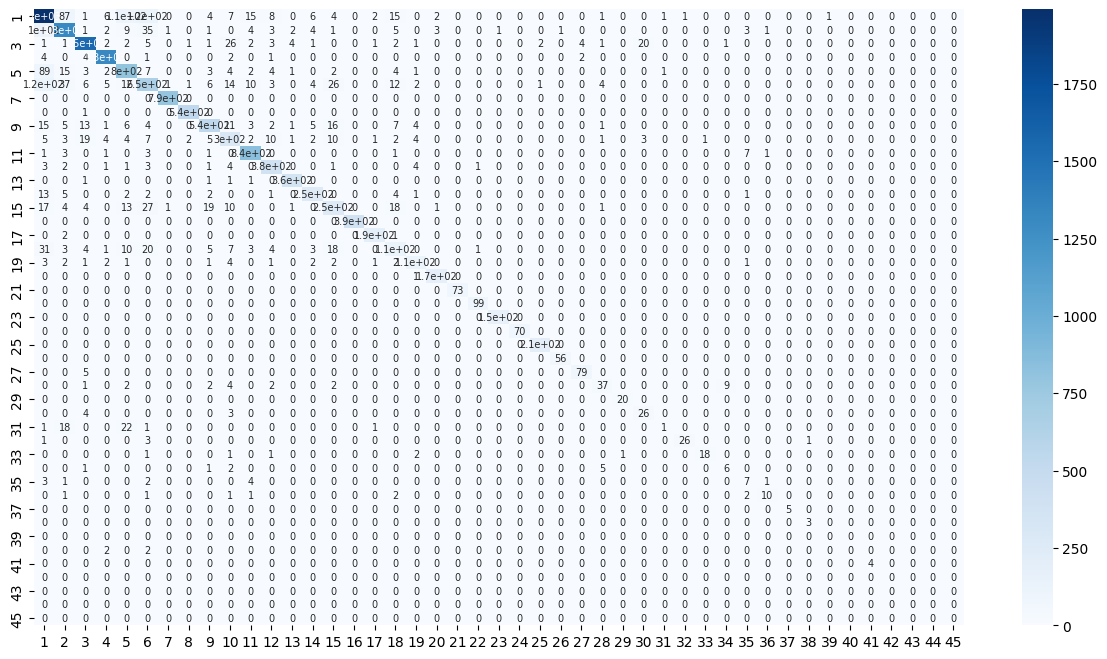


              precision    recall  f1-score   support

          NN       0.83      0.84      0.83      2383
         NNP       0.87      0.88      0.88      1502
          IN       0.96      0.95      0.95      1630
          DT       0.98      0.99      0.98      1335
         NNS       0.81      0.85      0.83       941
          JJ       0.73      0.71      0.72       918
         VBD       0.91      0.85      0.88       634
          RB       0.74      0.77      0.76       381
          CD       0.95      0.98      0.96       858
          VB       0.90      0.95      0.92       403
          CC       0.97      0.99      0.98       366
         VBZ       0.90      0.89      0.90       280
         VBN       0.75      0.68      0.72       366
          TO       1.00      1.00      1.00       386
         PRP       0.97      0.98      0.98       192
         VBG       0.60      0.50      0.55       221
         VBP       0.85      0.83      0.84       134
          MD       0.97   

In [63]:
f1_lstm_dropout = evaluation(lstm_model_dropout)
f1_scores.update({"lstm_dropout_model":f1_lstm_dropout})

Prediction...
11/11 [==============================] - 1s 59ms/step

Printing stats...

------------------------- F1 results -------------------------
F1-score on VALIDATION set: 0.7095774936533564
F1-score on TEST set: 0.7164178497178595
--------------------------------------------------------------

Printing confusion matrix...



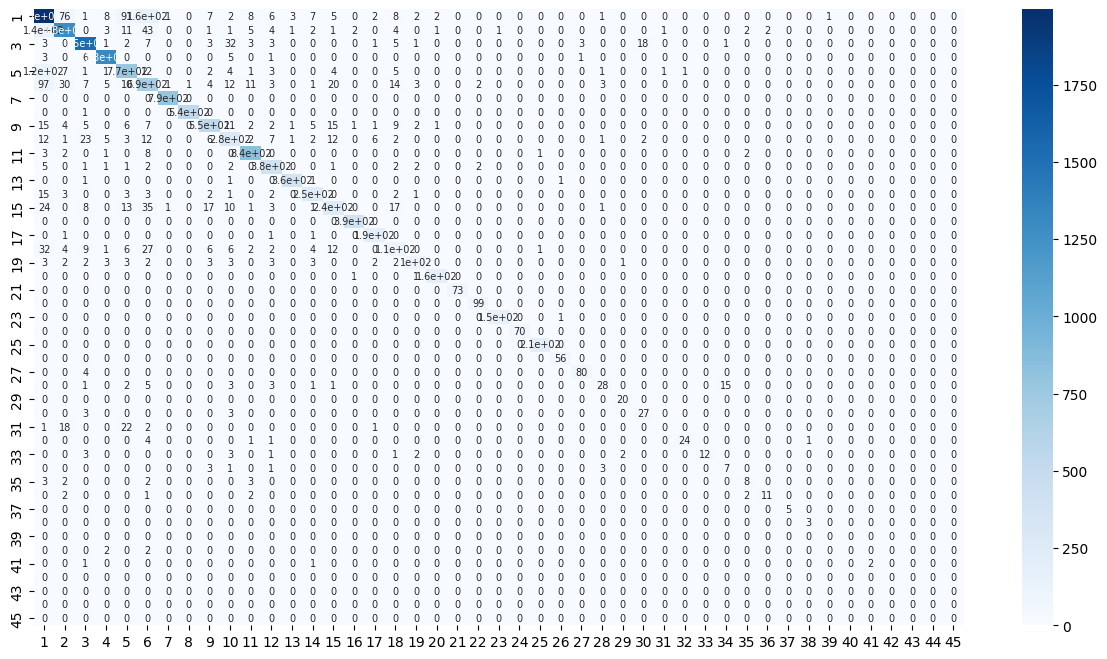


              precision    recall  f1-score   support

          NN       0.81      0.84      0.82      2383
         NNP       0.89      0.85      0.87      1502
          IN       0.95      0.95      0.95      1630
          DT       0.98      0.99      0.98      1335
         NNS       0.82      0.82      0.82       941
          JJ       0.68      0.76      0.71       918
         VBD       0.91      0.86      0.89       634
          RB       0.74      0.75      0.74       381
          CD       0.95      0.98      0.97       858
          VB       0.89      0.95      0.92       403
          CC       0.98      0.99      0.99       366
         VBZ       0.90      0.89      0.89       280
         VBN       0.77      0.64      0.70       366
          TO       0.99      1.00      0.99       386
         PRP       0.94      0.98      0.96       192
         VBG       0.61      0.49      0.54       221
         VBP       0.88      0.76      0.82       134
          MD       0.98   

In [64]:
f1_lstm_dropout2 = evaluation(lstm_model_dropout2)
f1_scores.update({"lstm_dropout2_model":f1_lstm_dropout2})

Prediction...
11/11 [==============================] - 0s 17ms/step

Printing stats...

------------------------- F1 results -------------------------
F1-score on VALIDATION set: 0.7169039943963752
F1-score on TEST set: 0.7243047267181991
--------------------------------------------------------------

Printing confusion matrix...



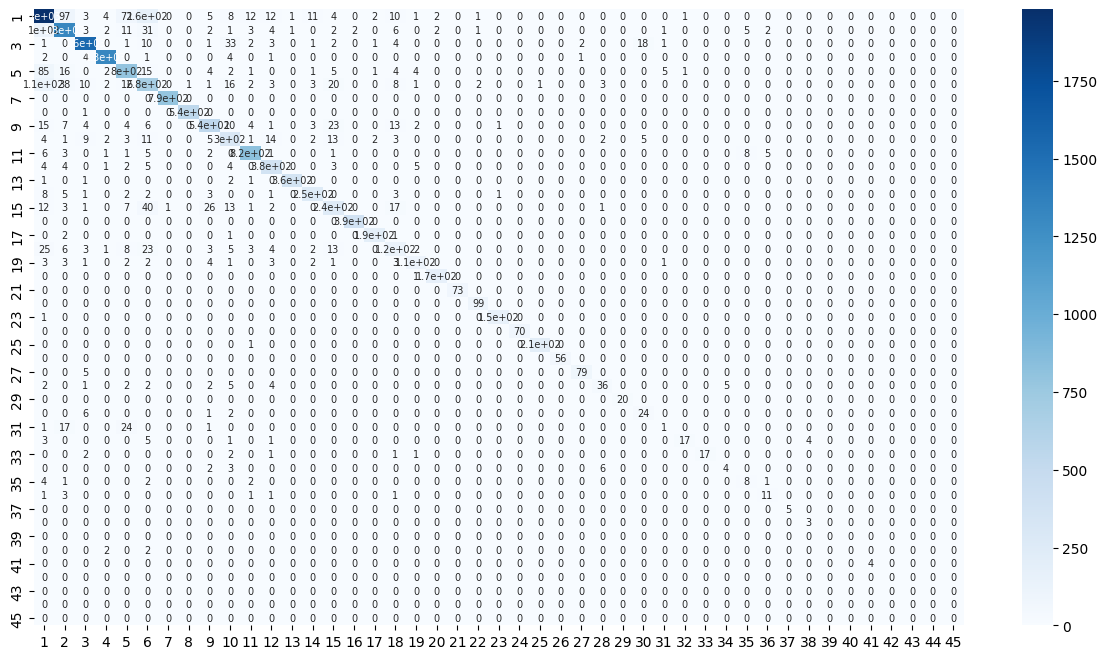


              precision    recall  f1-score   support

          NN       0.83      0.83      0.83      2383
         NNP       0.86      0.88      0.87      1502
          IN       0.97      0.95      0.96      1630
          DT       0.99      0.99      0.99      1335
         NNS       0.84      0.84      0.84       941
          JJ       0.68      0.74      0.71       918
         VBD       0.90      0.85      0.87       634
          RB       0.73      0.80      0.76       381
          CD       0.96      0.96      0.96       858
          VB       0.87      0.93      0.90       403
          CC       0.99      0.99      0.99       366
         VBZ       0.91      0.91      0.91       280
         VBN       0.74      0.66      0.70       366
          TO       0.99      1.00      1.00       386
         PRP       0.97      0.98      0.97       192
         VBG       0.62      0.56      0.59       221
         VBP       0.86      0.81      0.83       134
          MD       0.98   

In [65]:
f1_lstm_dropout3 = evaluation(lstm_model_dropout3)
f1_scores.update({"lstm_dropout3_model":f1_lstm_dropout3})

Prediction...
11/11 [==============================] - 1s 55ms/step

Printing stats...

------------------------- F1 results -------------------------
F1-score on VALIDATION set: 0.6745650700541118
F1-score on TEST set: 0.710595008484481
--------------------------------------------------------------

Printing confusion matrix...



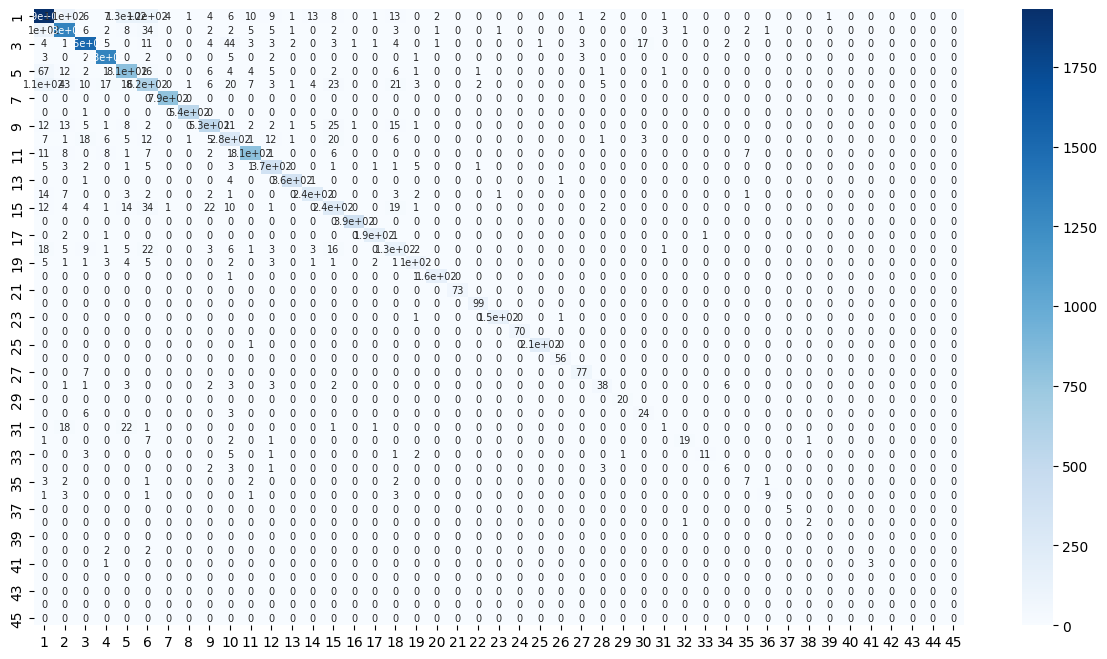


              precision    recall  f1-score   support

          NN       0.84      0.81      0.82      2383
         NNP       0.85      0.88      0.86      1502
          IN       0.95      0.93      0.94      1630
          DT       0.96      0.99      0.97      1335
         NNS       0.79      0.86      0.82       941
          JJ       0.68      0.68      0.68       918
         VBD       0.90      0.84      0.87       634
          RB       0.67      0.74      0.71       381
          CD       0.95      0.94      0.95       858
          VB       0.87      0.93      0.90       403
          CC       0.98      0.98      0.98       366
         VBZ       0.90      0.87      0.89       280
         VBN       0.69      0.66      0.67       366
          TO       0.99      1.00      1.00       386
         PRP       0.97      0.97      0.97       192
         VBG       0.56      0.57      0.57       221
         VBP       0.84      0.78      0.81       134
          MD       0.98   

In [66]:
f1_lstm_dropout4 = evaluation(lstm_model_dropout4)
f1_scores.update({"lstm_dropout4_model":f1_lstm_dropout4})

Prediction...
11/11 [==============================] - 0s 17ms/step

Printing stats...

------------------------- F1 results -------------------------
F1-score on VALIDATION set: 0.708425035428025
F1-score on TEST set: 0.7167775528859656
--------------------------------------------------------------

Printing confusion matrix...



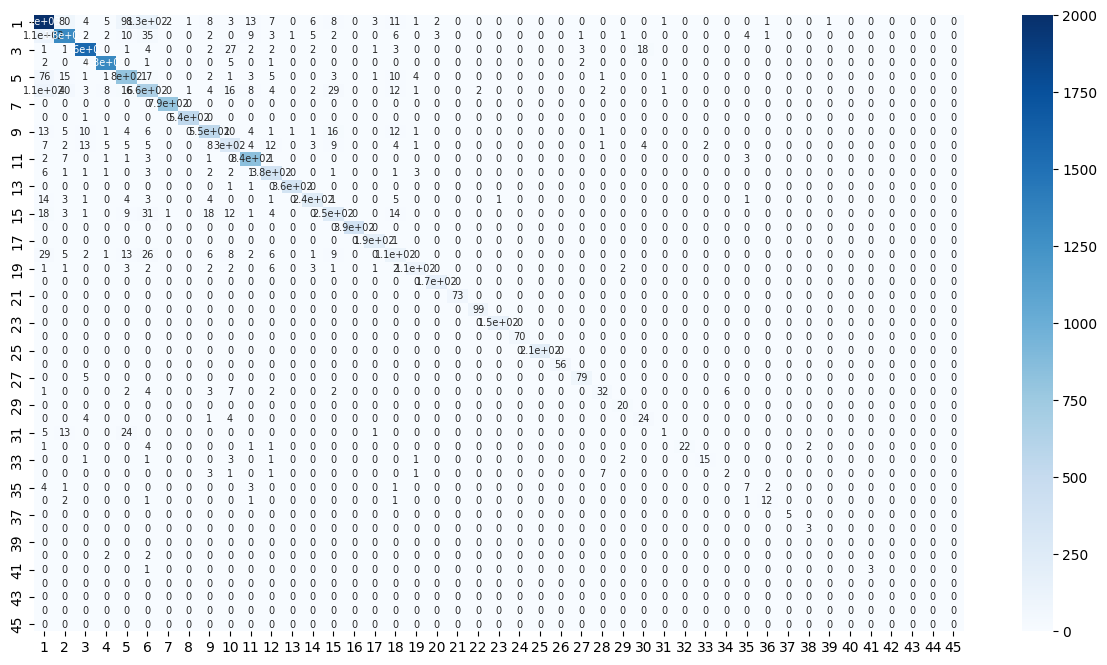


              precision    recall  f1-score   support

          NN       0.83      0.84      0.84      2383
         NNP       0.88      0.87      0.87      1502
          IN       0.97      0.96      0.96      1630
          DT       0.98      0.99      0.98      1335
         NNS       0.81      0.85      0.83       941
          JJ       0.70      0.72      0.71       918
         VBD       0.89      0.86      0.88       634
          RB       0.74      0.78      0.76       381
          CD       0.94      0.98      0.96       858
          VB       0.87      0.95      0.90       403
          CC       0.99      0.99      0.99       366
         VBZ       0.91      0.86      0.89       280
         VBN       0.76      0.69      0.72       366
          TO       1.00      1.00      1.00       386
         PRP       0.96      0.99      0.98       192
         VBG       0.58      0.51      0.54       221
         VBP       0.89      0.81      0.85       134
          MD       0.97   

In [67]:
f1_lstm_dropout5 = evaluation(lstm_model_dropout5)
f1_scores.update({"lstm_dropout5_model":f1_lstm_dropout5})

Prediction...
11/11 [==============================] - 1s 123ms/step

Printing stats...

------------------------- F1 results -------------------------
F1-score on VALIDATION set: 0.7035258830464821
F1-score on TEST set: 0.7143676449700689
--------------------------------------------------------------

Printing confusion matrix...



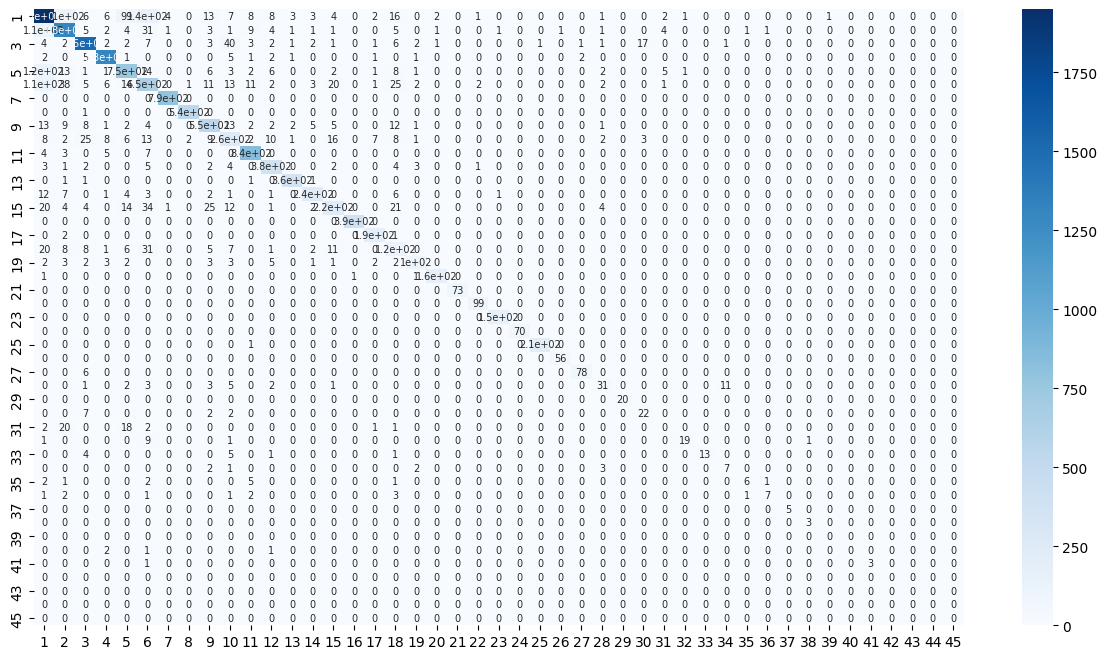


              precision    recall  f1-score   support

          NN       0.82      0.82      0.82      2383
         NNP       0.85      0.87      0.86      1502
          IN       0.94      0.94      0.94      1630
          DT       0.97      0.98      0.98      1335
         NNS       0.81      0.80      0.81       941
          JJ       0.68      0.71      0.69       918
         VBD       0.86      0.87      0.87       634
          RB       0.68      0.68      0.68       381
          CD       0.95      0.98      0.96       858
          VB       0.89      0.93      0.91       403
          CC       0.98      0.99      0.98       366
         VBZ       0.92      0.86      0.89       280
         VBN       0.78      0.61      0.69       366
          TO       1.00      1.00      1.00       386
         PRP       0.92      0.98      0.95       192
         VBG       0.50      0.55      0.52       221
         VBP       0.88      0.78      0.83       134
          MD       0.98   

In [69]:
f1_lstm_dropout6 = evaluation(lstm_model_dropout6)
f1_scores.update({"lstm_dropout6_model":f1_lstm_dropout6})

### Model: 2xBiLSTM + TD-Dense

Prediction...
11/11 [==============================] - 1s 80ms/step

Printing stats...

------------------------- F1 results -------------------------
F1-score on VALIDATION set: 0.7468204950685635
F1-score on TEST set: 0.7520989099566089
--------------------------------------------------------------

Printing confusion matrix...



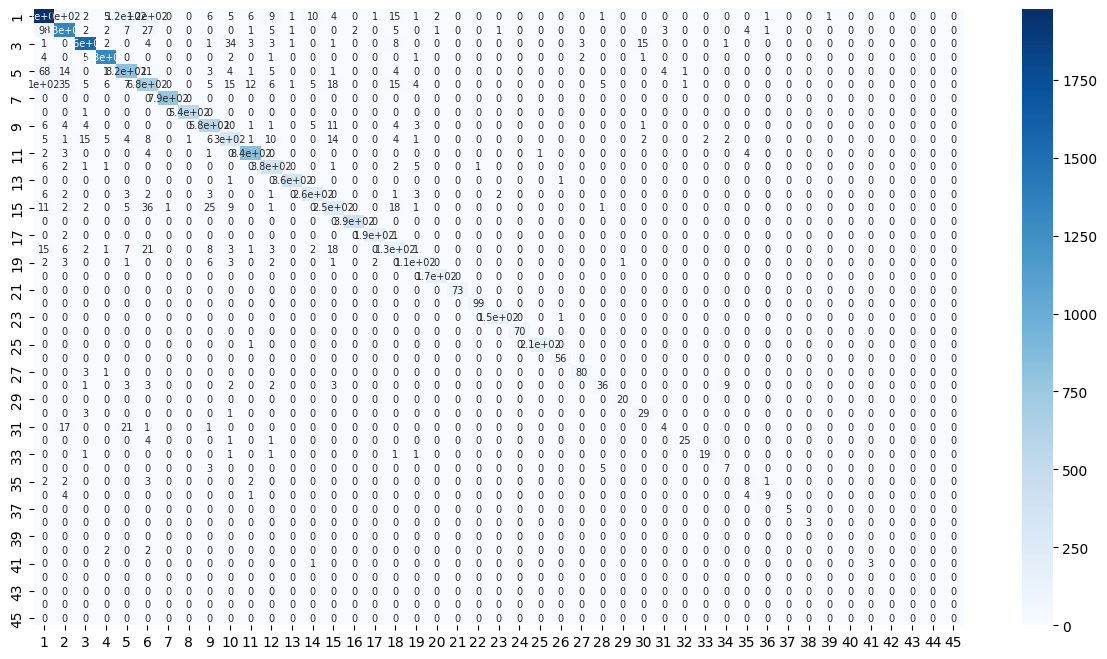


              precision    recall  f1-score   support

          NN       0.86      0.83      0.84      2383
         NNP       0.87      0.89      0.88      1502
          IN       0.97      0.95      0.96      1630
          DT       0.98      0.99      0.98      1335
         NNS       0.83      0.88      0.85       941
          JJ       0.73      0.74      0.74       918
         VBD       0.90      0.92      0.91       634
          RB       0.77      0.79      0.78       381
          CD       0.97      0.98      0.97       858
          VB       0.88      0.95      0.92       403
          CC       0.99      0.99      0.99       366
         VBZ       0.92      0.92      0.92       280
         VBN       0.78      0.69      0.73       366
          TO       0.99      1.00      1.00       386
         PRP       0.98      0.98      0.98       192
         VBG       0.63      0.60      0.62       221
         VBP       0.84      0.84      0.84       134
          MD       0.98   

In [70]:
f1_lstm2_model = evaluation(lstm2_model)
f1_scores.update({"lstm2_model":f1_lstm2_model})

Prediction...
11/11 [==============================] - 1s 83ms/step

Printing stats...

------------------------- F1 results -------------------------
F1-score on VALIDATION set: 0.7425818573941557
F1-score on TEST set: 0.7368706777067623
--------------------------------------------------------------

Printing confusion matrix...



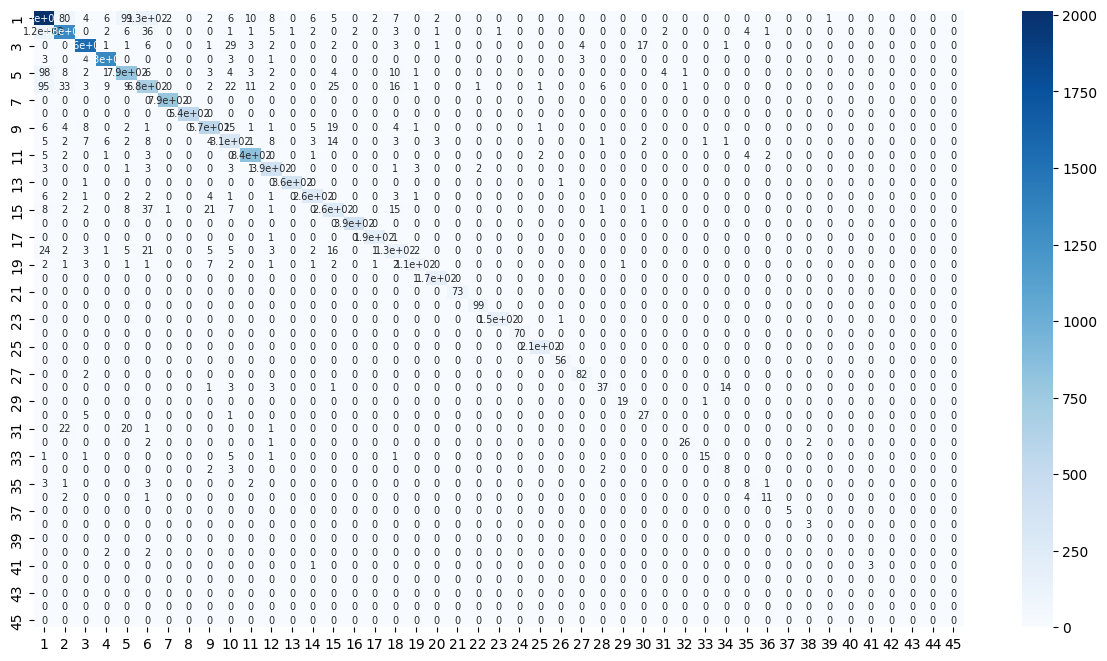


              precision    recall  f1-score   support

          NN       0.84      0.84      0.84      2383
         NNP       0.89      0.87      0.88      1502
          IN       0.97      0.96      0.96      1630
          DT       0.98      0.99      0.98      1335
         NNS       0.84      0.84      0.84       941
          JJ       0.72      0.74      0.73       918
         VBD       0.92      0.89      0.90       634
          RB       0.74      0.81      0.77       381
          CD       0.96      0.98      0.97       858
          VB       0.90      0.96      0.93       403
          CC       1.00      0.99      1.00       366
         VBZ       0.92      0.92      0.92       280
         VBN       0.75      0.72      0.73       366
          TO       0.99      1.00      1.00       386
         PRP       0.98      0.99      0.98       192
         VBG       0.66      0.59      0.62       221
         VBP       0.92      0.81      0.86       134
          MD       0.96   

In [108]:
f1_lstm2_model2 = evaluation(lstm2_model2)
f1_scores.update({"f1_lstm2_model2":f1_lstm2_model2})

Prediction...
11/11 [==============================] - 3s 274ms/step

Printing stats...

------------------------- F1 results -------------------------
F1-score on VALIDATION set: 0.7453200125533779
F1-score on TEST set: 0.7297375332203608
--------------------------------------------------------------

Printing confusion matrix...



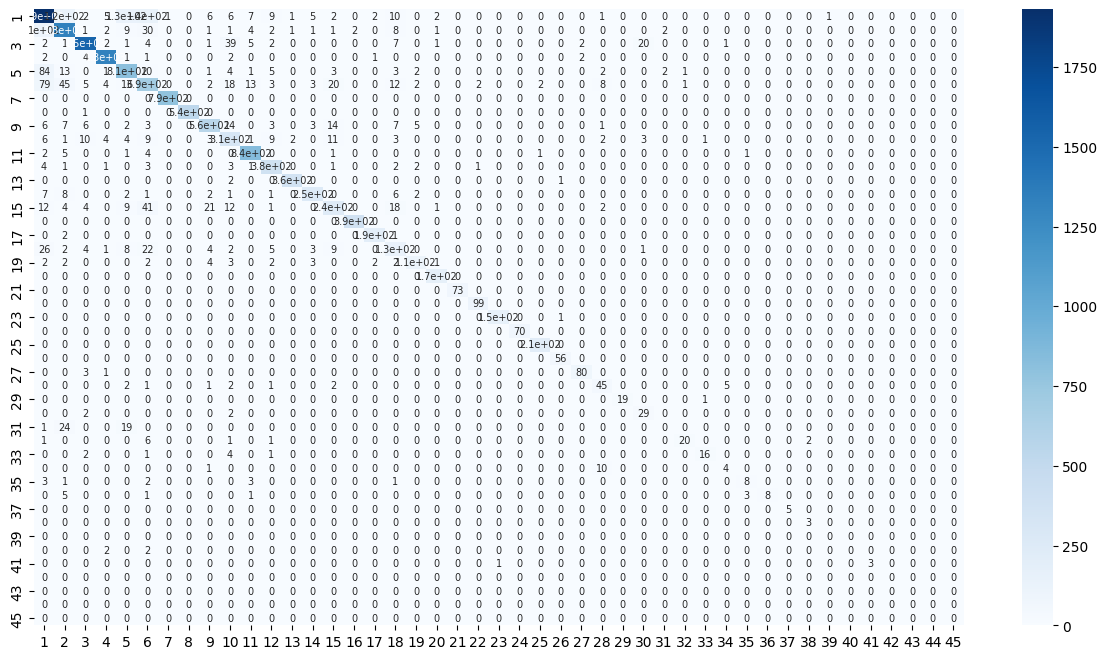


              precision    recall  f1-score   support

          NN       0.85      0.81      0.83      2383
         NNP       0.85      0.89      0.87      1502
          IN       0.97      0.95      0.96      1630
          DT       0.98      0.99      0.99      1335
         NNS       0.80      0.86      0.83       941
          JJ       0.71      0.75      0.73       918
         VBD       0.92      0.89      0.91       634
          RB       0.73      0.82      0.77       381
          CD       0.96      0.98      0.97       858
          VB       0.90      0.95      0.92       403
          CC       0.99      0.99      0.99       366
         VBZ       0.93      0.89      0.91       280
         VBN       0.79      0.66      0.72       366
          TO       0.99      1.00      1.00       386
         PRP       0.97      0.98      0.98       192
         VBG       0.63      0.61      0.62       221
         VBP       0.90      0.83      0.86       134
          MD       0.97   

In [109]:
f1_lstm2_model3 = evaluation(lstm2_model3)
f1_scores.update({"f1_lstm2_model3":f1_lstm2_model3})

### Model: Bi-GRU + TD-Dense

Prediction...
11/11 [==============================] - 0s 34ms/step

Printing stats...

------------------------- F1 results -------------------------
F1-score on VALIDATION set: 0.7487065006326011
F1-score on TEST set: 0.7431683815454664
--------------------------------------------------------------

Printing confusion matrix...



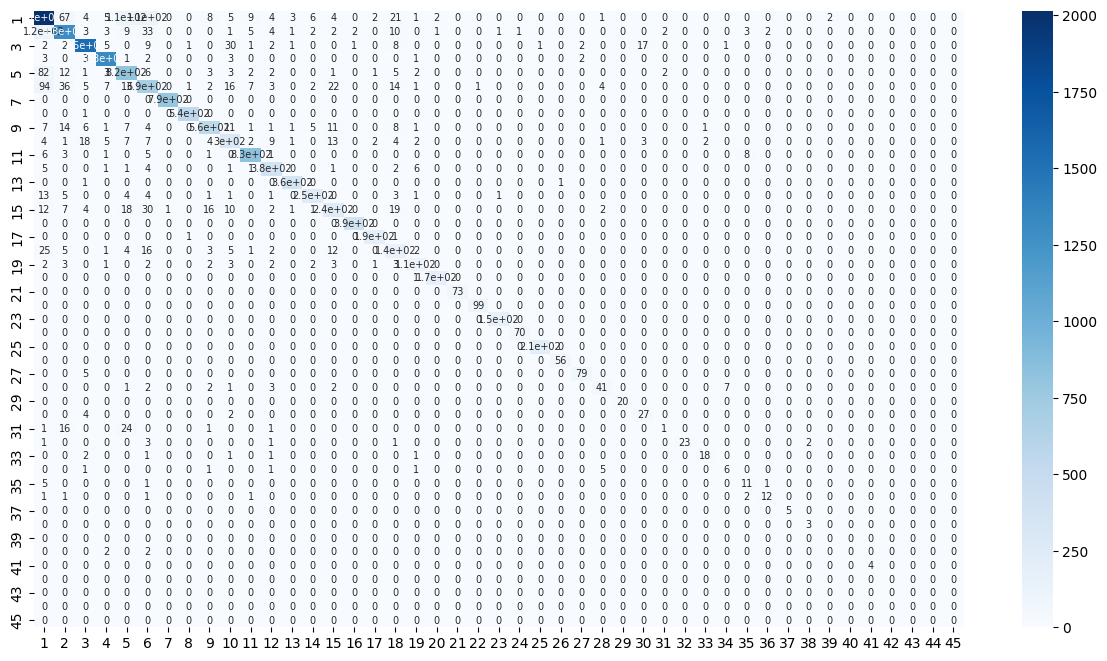


              precision    recall  f1-score   support

          NN       0.84      0.84      0.84      2383
         NNP       0.88      0.86      0.87      1502
          IN       0.96      0.95      0.96      1630
          DT       0.97      0.99      0.98      1335
         NNS       0.80      0.87      0.83       941
          JJ       0.74      0.75      0.74       918
         VBD       0.93      0.88      0.90       634
          RB       0.76      0.78      0.77       381
          CD       0.97      0.97      0.97       858
          VB       0.90      0.95      0.92       403
          CC       0.98      0.99      0.99       366
         VBZ       0.93      0.88      0.90       280
         VBN       0.77      0.66      0.71       366
          TO       0.99      1.00      1.00       386
         PRP       0.97      0.99      0.98       192
         VBG       0.59      0.66      0.62       221
         VBP       0.85      0.82      0.83       134
          MD       0.98   

In [71]:
f1_gru_model = evaluation(gru_model)
f1_scores.update({"gru_model":f1_gru_model})

### Model: BiLSTM + 2xTD-Dense

Prediction...
11/11 [==============================] - 1s 50ms/step

Printing stats...

------------------------- F1 results -------------------------
F1-score on VALIDATION set: 0.7175578680863305
F1-score on TEST set: 0.7214703171836646
--------------------------------------------------------------

Printing confusion matrix...



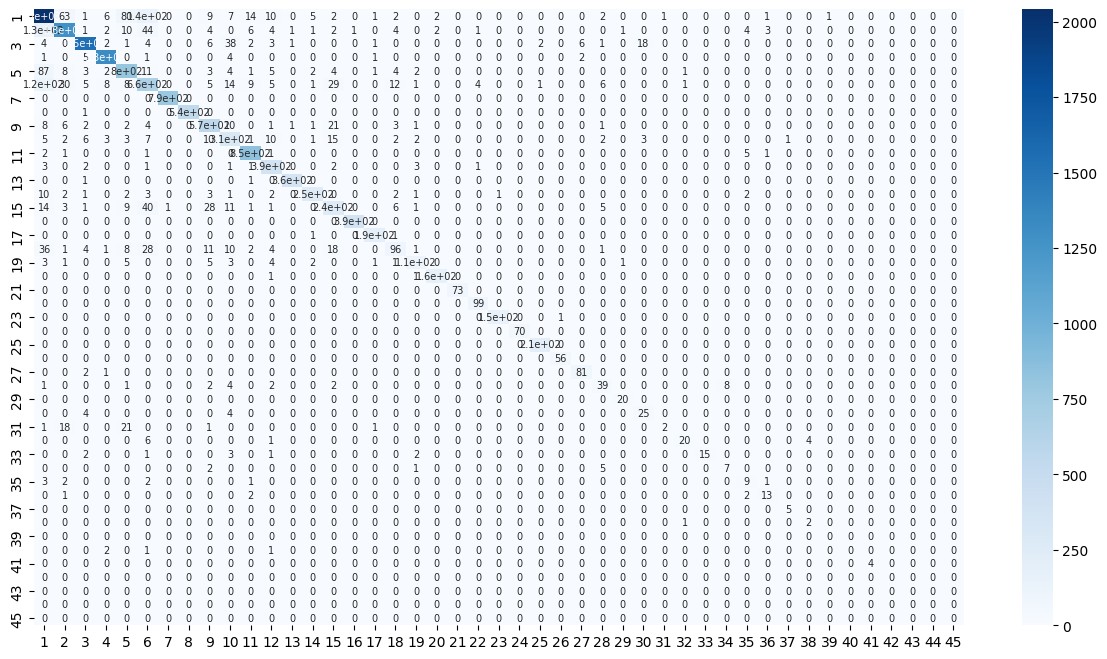


              precision    recall  f1-score   support

          NN       0.83      0.86      0.84      2383
         NNP       0.90      0.85      0.88      1502
          IN       0.97      0.95      0.96      1630
          DT       0.98      0.99      0.98      1335
         NNS       0.84      0.85      0.85       941
          JJ       0.70      0.72      0.71       918
         VBD       0.87      0.90      0.88       634
          RB       0.73      0.81      0.77       381
          CD       0.95      0.99      0.97       858
          VB       0.87      0.97      0.92       403
          CC       0.99      0.99      0.99       366
         VBZ       0.95      0.89      0.92       280
         VBN       0.72      0.67      0.69       366
          TO       1.00      1.00      1.00       386
         PRP       0.97      0.99      0.98       192
         VBG       0.72      0.43      0.54       221
         VBP       0.87      0.81      0.84       134
          MD       0.98   

In [72]:
f1_Dense2_model2 = evaluation(Dense2_model2)
f1_scores.update({"Dense2_model2":f1_Dense2_model2})

### F1 comparison

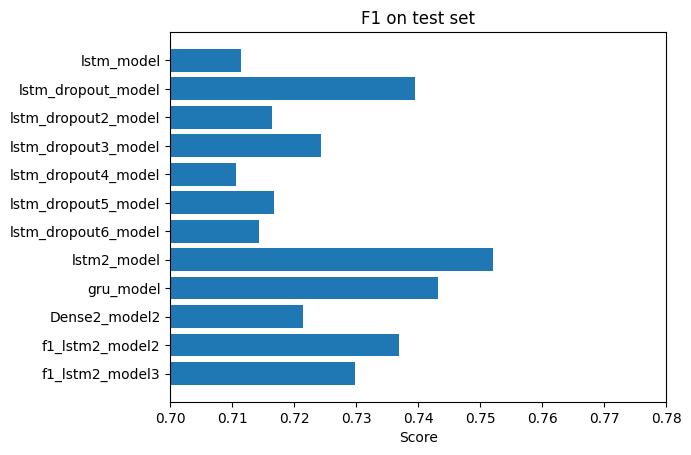

In [111]:
fig, ax = plt.subplots()
models = list(f1_scores.keys())
f1s = list(f1_scores.values())
ax.barh(models, f1s)
ax.invert_yaxis()
ax.set_xbound(lower=0.7, upper=0.78)
ax.set_xlabel('Score')
ax.set_title('F1 on test set')
plt.show()

The best result is obtained with the model which has 2 biLSTM layers and 1 dense

In [119]:
# prediction on validation and test set
y_pred_val = lstm2_model.predict(x_val, batch_size=64)
y_pred_test = lstm2_model.predict(x_test, batch_size=64)

print()

# concatenation of sentences, row = token,  col = prediction values for each class
y_pred_val = np.reshape(y_pred_val, (y_pred_val.shape[0]*y_pred_val.shape[1], y_pred_val.shape[2]))
y_pred_test = np.reshape(y_pred_test, (y_pred_test.shape[0]*y_pred_test.shape[1], y_pred_test.shape[2]))

# reshape of true values to commpare them
y_val_true = np.reshape(y_val, (y_val.shape[0]*y_val.shape[1], y_val.shape[2]))
y_test_true = np.reshape(y_test, (y_test.shape[0]*y_test.shape[1], y_test.shape[2]))

y_val_true_no_pad, y_pred_val_no_pad = remove_pad(np.argmax(y_val_true, axis=1), np.argmax(y_pred_val, axis=1))
y_test_true_no_pad, y_pred_test_no_pad = remove_pad(np.argmax(y_test_true, axis=1), np.argmax(y_pred_test, axis=1))

print("-"*20, "Previous F1 results", "-"*20)
compute_f1(y_val_true_no_pad, y_pred_val_no_pad, "VALIDATION set")
f1_test = compute_f1(y_test_true_no_pad, y_pred_test_no_pad, "TEST set")
print("-"*61)

print("-"*22, "New F1 results", "-"*23)
compute_f1_zero_excluded(y_val_true_no_pad, y_pred_val_no_pad, "VALIDATION set")
compute_f1_zero_excluded(y_test_true_no_pad, y_pred_test_no_pad, "TEST set")
print("-"*61)

11/11 [==============================] - 1s 127ms/step

-------------------- Previous F1 results --------------------
F1-score on VALIDATION set: 0.7468204950685635
F1-score on TEST set: 0.7520989099566089
-------------------------------------------------------------
---------------------- New F1 results -----------------------
F1-score on VALIDATION set: 0.7468204950685635
F1-score on TEST set: 0.809241767099466
-------------------------------------------------------------


## Error analysis

In [89]:
y_pred = lstm_model.predict(x_test, batch_size=256)
y_pred = np.reshape(y_pred, (y_pred.shape[0]*y_pred.shape[1], y_pred.shape[2]))
y_test_true = np.reshape(y_test, (y_test.shape[0]*y_test.shape[1], y_test.shape[2]))
y_test_true_no_pad, y_pred = remove_pad(np.argmax(y_test_true, axis=1), np.argmax(y_pred, axis=1))

print(y_pred[0])
print(y_test_true_no_pad[0])

3/3 [==============================] - 0s 16ms/step
2
2


# Discussion and Conclusion



1.   As we can see from the data from accuracy and F1 score the results are coherent in the test set compared to validation set
2.   Due to a limited and unbalanced dataset it is very difficult to overperform certain results, infact all model reach similar accuracy in predicting classes. For the same reasons the models tend to overfit very quickly in predicting train set (this is the reason that dropout improve performances)
3. We also noticed that some classes are not even supported and this leads to poorer results when taking into account F1 as the main metric, because that classes are considered as 0 in f1 computation. 
4. The best model is ...... as it's shown in the chart about F1 
5. Despite we are looking to the pure score, it is important to take into account also some other parameters. Fow example the number of epochs employed: We can emphasise that ....



## Some advices to improve the task 

In [73]:
# possiamo escludere le classi senza supporto??? 
# escludiamo altre classi durante il notebook?
# usare zero division = 1 nella computation della f1? 